**IMDb**（Internet Movie Datebase ）是全球最大的互联网影视数据库，而[Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) 是一个根据IMDB上电影评论而建立的数据集。它由斯坦福大学于 2011 年发布。

![image-20201226152702981](images/image-20201226152702981.png)

## 获取数据

首先引入需要的包。

In [1]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf
from qbz95 import utils as qutils

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()
nltk.download('stopwords')

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [3]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr



output_path = os.path.abspath('./output')
data_name = 'imdb'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['Negative', 'Positive']

params = {
    'data_name': data_name,
    'data_path': data_path,
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'text_columns': 'snps_sa_comments',
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'stop_words':stopwords.words('english'),
    'batch_size': 32,    
    'max_features': 20000,
    'sequence_length': 500,    
    'epochs': 3,    
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':True,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.6, 'layer_count':1, 'units':256, 'epochs':15},
        'rnn':{'dropout':0.4, 'embedding_dim':200, 'units':200, 'epochs':5},
        'embedding':{'dropout':0.4, 'embedding_dim':200, 'epochs':15},
        'sepcnn':{'dropout':0.4, 'epochs': 10, 'batch_size':128},
        'tl':{'dropout':0.4, 'trainable':True, 'layer_count':1, 'unit':64, 'epochs': 10},
        'pg':{'dropout':0.4, 'embedding_dim':300, 'units':80, 'epochs':20, 'learning_rate':0.0005},  
    },
    'embedding_paths':{
        'cc_en_300':os.path.join(word_vectors_path, 'snps', 'cc.en.300.vec'),
        'fasttext_crawl_300d_2M':os.path.join(word_vectors_path, 'fasttext-crawl-300d-2M.vec'),
        'glove_twitter_27B_200d':os.path.join(word_vectors_path, 'glove.twitter.27B.200d.txt')
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
model_results.clear()

2021-12-06 06:18:26,758: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json


### 下载数据

开始下载数据。

In [4]:
dataset_dir =  os.path.join(os.path.expanduser('~'), '.keras/datasets/aclImdb') 
if not os.path.exists(dataset_dir):
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url, untar=True)
    dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
    print(dataset_dir)

![image-20201217095446441](images/image-20201217095446441.png)

下面是压缩文件解开后的目录结构。

![image-20201104115404253](images/image-20201104115404253.png)

其中train和test目录包含了实际的文本数据，详细说明见[IMDB](https://eipi10.cn/others/2020/10/22/dataset/#imdb---large-movie-review-dataset)。

### 查看数据

下面看一看实际的数据是啥样的。

In [5]:
def get_files(base_dir):
    pos_dir = os.path.join(base_dir, 'pos')
    pos_files = os.listdir(pos_dir)
    pos_files = [os.path.join(pos_dir, file_name) for file_name in pos_files]
    
    neg_dir = os.path.join(base_dir, 'neg')
    neg_files = os.listdir(neg_dir)
    neg_files = [os.path.join(neg_dir, file_name) for file_name in neg_files]    

    return pos_files, neg_files

train_pos_files, train_neg_files = get_files(os.path.join(dataset_dir, 'train'))
test_pos_files, test_files = get_files(os.path.join(dataset_dir, 'test'))
    
print('train dataset: {} positive reviews, {} negative reviews'.format(len(train_pos_files), len(train_neg_files)))
print('test dataset: {} positive reviews, {} negative reviews'.format(len(test_pos_files), len(test_files)))

train dataset: 12500 positive reviews, 12500 negative reviews
test dataset: 12500 positive reviews, 12500 negative reviews


![image-20201217115036617](images/image-20201217115036617.png)

首先看一看正面的评论。

In [6]:
for file_path in train_pos_files[0:3]:    
    print('-'*30 + file_path + '-'*30 )
    with open(file_path) as f:
        comment = f.read() 
        print(comment if len(comment)<=800 else comment[0:800]+' ...') 

------------------------------/root/.keras/datasets/aclImdb/train/pos/127_7.txt------------------------------
Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn't really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I'd have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is presented as a dream/nightmare, and making it too coherent would spoil the effect. <br /><br />This movie is unrelentingly grim--"noir" in more than one sense; one never sees the sun shine. Grim, but intriguing, and frightening.
------------------------------/root/.keras/datasets/aclImdb/train/pos/126_10.txt------------------------------
Zentropa is the most original movie I've seen in y

![image-20201217111649607](images/image-20201217111649607.png)

然后看一看负面的评论。

In [7]:
for file_path in train_neg_files[0:3]:    
    print('-'*30 + file_path + '-'*30 )
    with open(file_path) as f:
        comment = f.read() 
        print(comment if len(comment)<=800 else comment[0:800]+' ...')

------------------------------/root/.keras/datasets/aclImdb/train/neg/127_4.txt------------------------------
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher ...
------------------------------/root/.keras/datasets/aclImdb/train/neg/126_1.txt------

![image-20201217100213645](images/image-20201217100213645.png)

## 探索数据

接下来，对把数据加载进内存，进行深入一些的探索。

### 基本信息

In [8]:
def get_samples(texts, labels, rate):
    indexs = np.arange(len(texts))
    sample_indexs, _, sample_labels, _ = train_test_split(indexs, labels,                                                          
                                                          test_size=1-rate,
                                                          random_state=12)
    sample_texts = [texts[index] for index in sample_indexs]
    return sample_texts, sample_labels    

def load_imdb_sentiment_analysis_dataset(imdb_data_path, seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

(train_texts, train_labels), (test_texts, test_labels) = load_imdb_sentiment_analysis_dataset(dataset_dir)

if params.sample_perecent<1:
    train_texts, train_labels = get_samples(train_texts, train_labels, rate=params.sample_perecent)
    test_texts, test_labels = get_samples(test_texts, test_labels, rate=params.sample_perecent)

print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

train_texts.length=25000, train_labels.shape=(25000,)
test_texts.length=25000, test_labels.shape=(25000,)


![image-20201217122349480](images/image-20201217122349480.png)

### 类别分布

下面看看类别的分布。可以看到数据分为Positive和Negative两类，数据分布完全均匀。

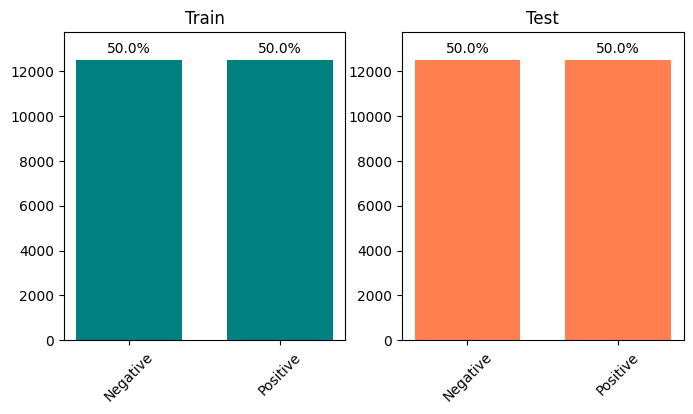

In [9]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



### 文本长度分布

分析训练集和测试集的文本长度分布是否相似。

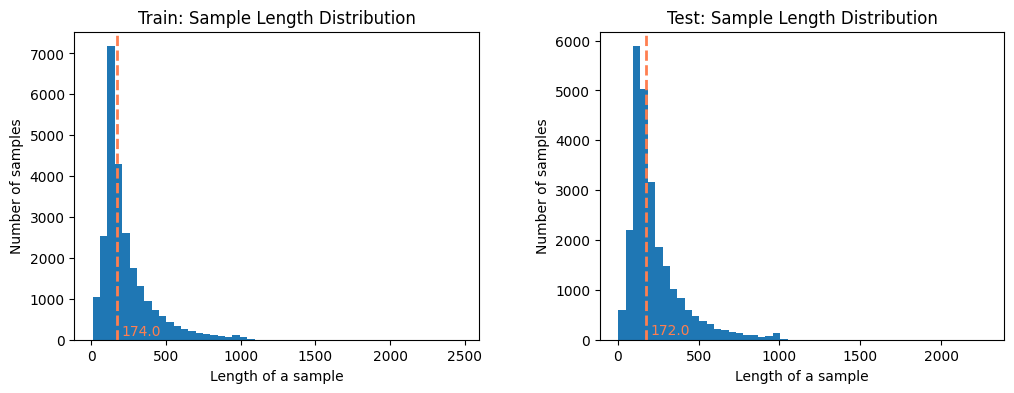

train：mean=233.79 variance=30181.96
test：mean=228.53 variance=28520.56


In [10]:
train_text_lengths = [len(s.split()) for s in train_texts]
test_text_lengths = [len(s.split()) for s in test_texts]
qtf.utils.plot_length_distribution(train_text_lengths, test_text_lengths)

print('train：mean={:0.2f} variance={:0.2f}'.format(np.mean(train_text_lengths), 
                                                    np.var(train_text_lengths)))
print('test：mean={:0.2f} variance={:0.2f}'.format(np.mean(test_text_lengths), 
                                                   np.var(test_text_lengths)))


通过图形，中位数，均值和方差的比较，可以认为训练集和测试集文本长度的分布是非常相似的。下面用卡方检验来比较训练集和测试集是否有显著差异。

In [11]:
def process_length(lengths):
    cut_points = [0,99,199,299,399,499,599,699,799,10000]
    labels = ["0-99","100-199","200-299","300-399","400-499","500-599", "600-699","700-799","800+"]
    return pd.cut(lengths, cut_points, labels=labels)

def get_observed(df, column1, column2):
    df_observed = pd.crosstab(
        df[column1],
        df[column2]
    )    
    return df_observed
    
def get_expected(df_observed):
    observed = df_observed.to_numpy()
    reduce_row = observed.sum(axis=0, keepdims=True)/observed.sum()
    reduce_col = observed.sum(axis=1, keepdims=True)

    expected = reduce_col.dot(reduce_row)
    df_expected = pd.DataFrame(expected, index=df_observed.index, columns=df_observed.columns)
    return df_expected
  
def show_sum(df):
    df.columns =  df.columns.tolist()  
    df = df.reset_index()
    s = df.melt(df.columns[0], var_name=' ')
    ct = pd.crosstab(index=s[df.columns[0]], columns=s.iloc[:,1], values=s.value, 
                     aggfunc='sum', margins=True, margins_name='合计',
                     rownames=[''], 
               ) 
    display(ct)
    
length = train_text_lengths + test_text_lengths
dataset = ['train']*len(train_text_lengths) + ['test']*len(test_text_lengths)

df_length = pd.DataFrame({"dataset":dataset, "length":length})
df_length['len'] = process_length(length)
df_observed = get_observed(df_length, 'dataset', 'len')
# display(df_length)

print('-'*25, 'Observed', '-'*25)
show_sum(df_observed)

print('-'*25, 'Expected', '-'*25)
df_expected = get_expected(df_observed)
show_sum(df_expected)

------------------------- Observed -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,3091,11744,4697,2321,1251,752,434,289,421,25000
train,2926,11654,4665,2385,1340,786,464,307,473,25000
合计,6017,23398,9362,4706,2591,1538,898,596,894,50000


------------------------- Expected -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,3008.5,11699.0,4681.0,2353.0,1295.5,769.0,449.0,298.0,447.0,25000.0
train,3008.5,11699.0,4681.0,2353.0,1295.5,769.0,449.0,298.0,447.0,25000.0
合计,6017.0,23398.0,9362.0,4706.0,2591.0,1538.0,898.0,596.0,894.0,50000.0


![image-20210101174143400](images/image-20210101174143400.png)

然后进行卡方检验。可以看到p_value>0.05，所以接受原假设——数据集来源和文本长度是独立的，也就是说接受训练集和测试集是是相似的分布。

In [12]:
observed = df_observed.to_numpy()
expected = df_expected.to_numpy()

chi_squared_stat = ((observed-expected)**2/expected).sum()
print('chi_squared_stat =', chi_squared_stat)

df = np.prod(np.array(observed.shape) - 1)
critical_value  = stats.chi2.ppf(q=0.95, df=df)  #0.95:置信水平, df:自由度
print('critical_value =', critical_value)        #临界值:拒绝域的边界, 当卡方值大于临界值，则原假设不成立，备择假设成立

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=df)
print('p_value =', p_value)

chi_squared_stat = 14.229826210223425
critical_value = 15.50731305586545
p_value = 0.07596828551367163



### 词频分布

分析训练集和测试集的词频分布是否相似。下面代码中，去除了一些stopwords。

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


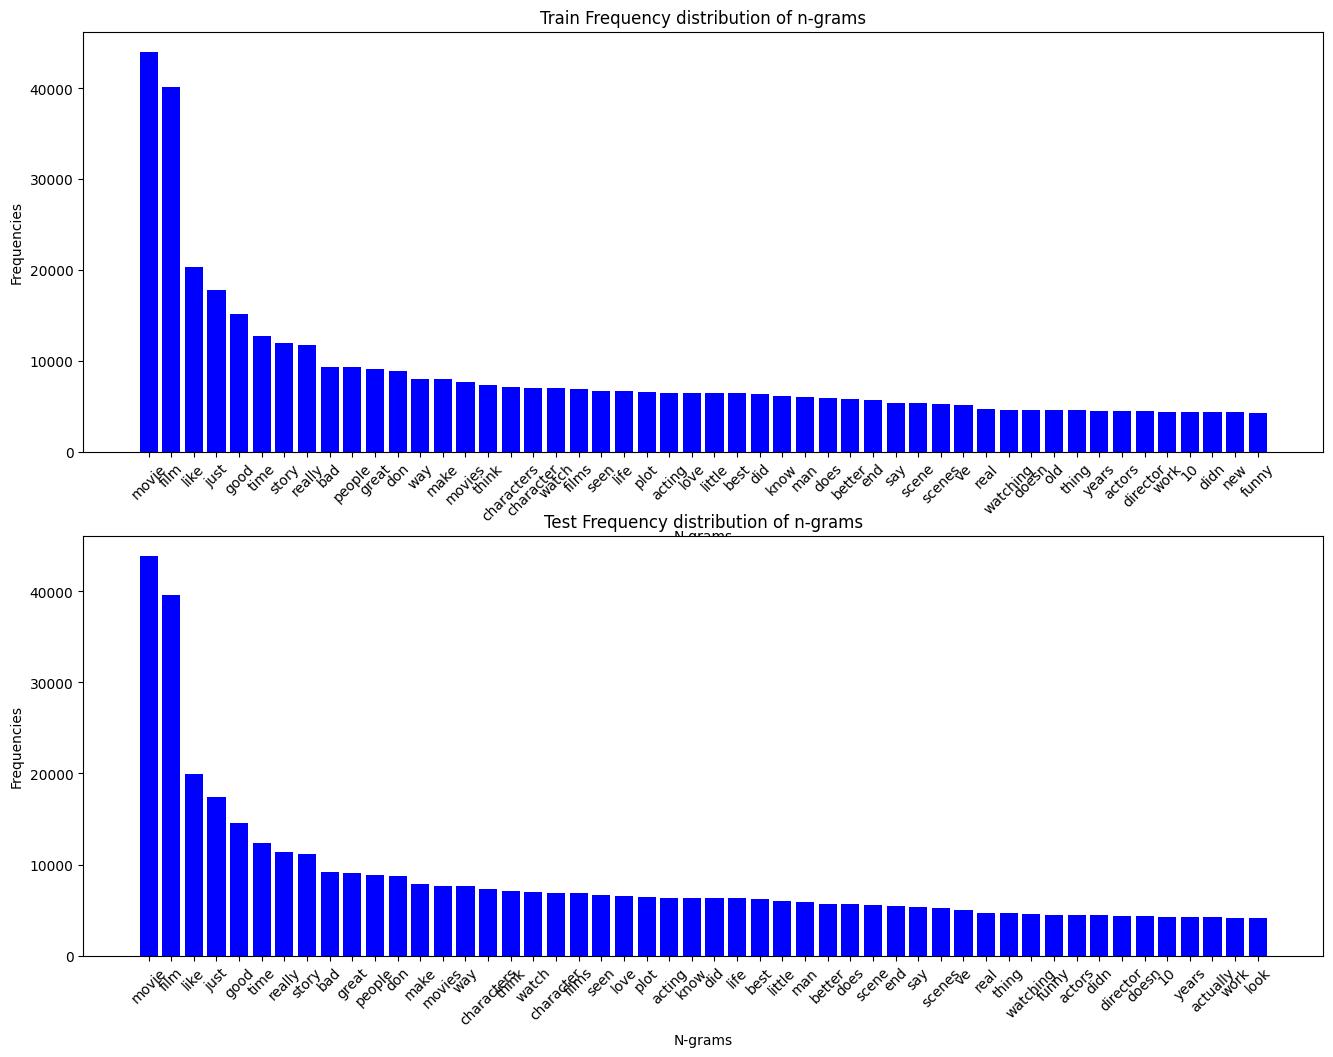

In [13]:
qtf.utils.plot_frequency_distribution(train_texts, test_texts) 

In [14]:
word_counter = Counter()
for s in train_texts:
    word_counter.update(s.split())
for s in test_texts:
    word_counter.update(s.split())   

print('Number of Vocabulary: {}'.format(len(word_counter)))

for word in list(word_counter):
    if word_counter[word]<25: word_counter.pop(word)
        
print('Number of Vocabulary: {}'.format(len(word_counter)))

Number of Vocabulary: 438729
Number of Vocabulary: 23078


![image-20201217142728260](images/image-20201217142728260.png)

上面可以看到词频大于等于100次的词汇有7706个。

## 准备数据

不同的模型需要准备不同的数据，所以徐要确定一下要构建哪种模型。

### 模型选择

下图是google在两年前提出一个选择流程图。

![image-20201217135347743](images/image-20201217135347743.png)

1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a simple multi-layer perceptron (MLP) model to classify them (left branch in the flowchart below):
   a. Split the samples into word n-grams; convert the n-grams into vectors.
     b. Score the importance of the vectors and then select the top 20K using the scores.
   c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a sepCNN model to classify them (right branch in the flowchart below):
   a. Split the samples into words; select the top 20K words based on their frequency.
   b. Convert the samples into word sequence vectors.
   c. If the original number of samples/number of words per sample ratio is less   than 15K, using a fine-tuned pre-trained embedding with the sepCNN  model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.

In [15]:
length_median = np.median(train_text_lengths)
train_number = len(train_texts)
print ("[the number of samples]/[number of words per sample] = {:0.1f}".format(train_number/length_median))

[the number of samples]/[number of words per sample] = 143.7


可以看到这个比例大大小于15k，所以我们从N-gram模型开始，但是同时我们也会为Sequence模型准备数据。数据准备有如下几个过程。
1. Standardization 
   
   文本标准化操作，去除一些不合规范的字符或单词等。比如：去除拼音和HTML标记
   
   
2. Tokenization

   把文本字符串拆分成Token。对于英文最常见的拆分方式是根据空格拆分
   
   
3. Vectorization

   把Token转化为向量。
   

接下来，我们将分别为N-gram模型和Sequence模型准备数据。

### N-gram + Preprocess

在N-gram模型中，Tokenization一般使用unigrams + bigrams的方式把文本转成Token，而Vectorization过程，一般先统计Token的BOW（Bag of Words，词袋模型），然后采用tf-idf在对词频进行平衡。

In [16]:
stop_words = params.stop_words if params.use_stop_words else None
generator = qtf.classification.NgramGenerator('ngram_preproess', standardize=qtf.text.standardize_text1,
                                    texts=train_texts, labels=train_labels, max_feature=params.max_features, 
                                    stop_words=stop_words)
ngram_datasets1 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                              generator=generator, batch_size=params.batch_size)

In [17]:
data, labels = iter(ngram_datasets1.train_dataset).next()
print(type(data))
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(tf.sparse.to_dense(data), labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(np.any(item.numpy()>0), item.shape)

<class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>
(32, 20000) (32,)
---------------------------------------- Positive ----------------------------------------
True (20000,)
---------------------------------------- Negative ----------------------------------------
True (20000,)
---------------------------------------- Negative ----------------------------------------
True (20000,)
---------------------------------------- Negative ----------------------------------------
True (20000,)
---------------------------------------- Negative ----------------------------------------
True (20000,)


### Sequence + Preprocess

In [18]:
generator = qtf.classification.SequenceGenerator('sequence_prepross', standardize=qtf.text.standardize_text1, 
                                       texts=train_texts, max_features=params.max_features, 
                                       max_sequence_length=params.sequence_length)
sequence_datasets1 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                                 generator=generator, batch_size=params.batch_size) 

In [19]:
data, labels = iter(sequence_datasets1.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 500) (32,)
---------------------------------------- Positive ----------------------------------------
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     

### N-gram + Process

In [20]:
generator = qtf.classification.LayerGenerator.get_ngram_layer(name='ngram_map', standardize=qtf.text.standardize_tf_text1, 
                                                        texts=train_texts[0:1000], max_features=params.max_features)
ngram_datasets2 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                              generator=generator, batch_size=params.batch_size)

In [21]:
data, labels = iter(ngram_datasets2.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 20000) (32,)
---------------------------------------- Negative ----------------------------------------
[1302.2052     21.534168   15.965419 ...    0.          0.
    0.      ] (20000,)
---------------------------------------- Negative ----------------------------------------
[2352.848      38.900433   15.965419 ...    0.          0.
    0.      ] (20000,)
---------------------------------------- Negative ----------------------------------------
[725.0915      6.946506    5.5531893 ...   0.          0.
   0.       ] (20000,)
---------------------------------------- Positive ----------------------------------------
[162.77565      2.7786024    0.69414866 ...   0.           0.
   0.        ] (20000,)
---------------------------------------- Negative ----------------------------------------
[656.03516    4.862554   8.329784 ...   0.         0.         0.      ] (20000,)


### Sequence + Process

![Embedding Layer](images/EmbeddingLayer.png)

如上图所示，和N-gram模型不同，Sequence模型并不统计词频，它保持了文本的原始顺序，把其中的每个词汇单独变成一个One-hot向量，然后采用Word embedding的方式生成更加有意义的词向量，最后输出到RNN，CNN等模型中。

In [22]:
ngrams = (1, 2)
output_mode = 'tf-idf'
max_sequence_length = None
data = train_texts[0:1000]

layer = TextVectorization(
            max_tokens=params.max_features, standardize=qtf.text.standardize_tf_text1,
            split='whitespace', ngrams=ngrams, output_mode=output_mode,
            output_sequence_length=max_sequence_length, pad_to_max_tokens=False,
            vocabulary=None
        )



In [23]:
generator = qtf.classification.LayerGenerator.get_sequence_layer(name='sequence_map', 
                                                       standardize=qtf.text.standardize_tf_text1, 
                                                       texts=train_texts[0:1000], 
                                                       max_features=params.max_features,
                                                       max_sequence_length=params.sequence_length)
sequence_datasets2 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels,   
                                                 generator=generator, batch_size=params.batch_size)

In [24]:
data, labels = iter(sequence_datasets2.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 500) (32,)
---------------------------------------- Positive ----------------------------------------
[   31    56    61   358    15    46    28   121   227    59   270    17
  1237    17  2226  4081    56   213     2    67     8 19293   270    41
   630   360     3    10    10    12    36   250   186     8  3973   103
     3    17    84  7646   249     4    13   115  3018     6   129    13
   192    26    42     3     7   283     4    52    25   834     1     1
     4    53    16    27     8    42    54    15  1725     7     1    56
  3404     1     3    62     9    44    43   700    15    13    56   108
   262    62     9    11     3     2   177   239    19  4081     3    30
     9    44  1306    24     2   266     3    10    10     2   117     7
   106   493   197     6    23    15    18   191    40   303     8  2494
     3    40     2  3953     1     8     1  6704     8     1     3    12
    18  4394     4  1814     5    44   759   191     3    10    10    25
    33     8   92

In [25]:
vocabulary = generator.layer.get_vocabulary()

embedding_files = [params.embedding_paths.fasttext_crawl_300d_2M]
embedding_matrix_fasttext = qtf.text.load_embedding_matrix(embedding_files,
                                                           vocabulary=vocabulary,
                                                           max_features=params.max_features,
                                                           max_length=1000000,
                                                           ignore_rows=0
                                                           )

2021-12-06 06:19:59,866: INFO: --------------------------------------------------------------------------------
2021-12-06 06:21:10,042: INFO: Loaded 1000000 word vectors. the vector size is 300
2021-12-06 06:21:10,104: INFO: embedding_matrix.shape: (19776, 300)
2021-12-06 06:21:10,104: INFO: match count: 17746
2021-12-06 06:21:10,105: INFO: missing word count: 2030




##  模型

### MLP

#### mp1

2021-12-06 06:21:10,610: INFO: model_params.mlp1.dropout=0.6
2021-12-06 06:21:10,611: INFO: model_params.mlp1.layer_count=1
2021-12-06 06:21:10,612: INFO: model_params.mlp1.units=256
2021-12-06 06:21:10,641: INFO: output_bias=[-0.69314718 -0.69314718]
2021-12-06 06:21:10,650: INFO: learning_rate=0.001
2021-12-06 06:21:10,651: INFO: model_params.mlp1.clip_value=None
2021-12-06 06:21:10,659: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1
2021-12-06 06:21:10,662: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1, monitor=val_accuracy)
2021-12-06 06:21:10,663: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-12-06 06:21:10,663: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-12-06 06:21:10,664: INFO: use LearningRateScheduler()
2021-12-06 06:21:10,664: 

SparseTensorSpec(TensorShape([32, 20000]), tf.float32)
Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 lambda (Lambda)             (None, 20000)             0         
                                                                 
 dropout (Dropout)           (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 256)               5120256   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total p

2021-12-06 06:21:17,141: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1/assets


781/781 [==============================] - 6s 7ms/step - loss: 0.3963 - accuracy: 0.8268 - val_loss: 0.2765 - val_accuracy: 0.8881 - lr: 0.0010
Epoch 2/2
781/781 [==============================] - 4s 6ms/step - loss: 0.2613 - accuracy: 0.8919 - val_loss: 0.2719 - val_accuracy: 0.8876 - lr: 0.0010


2021-12-06 06:21:21,542: INFO: finish training [elapsed time: 10.88 seconds]


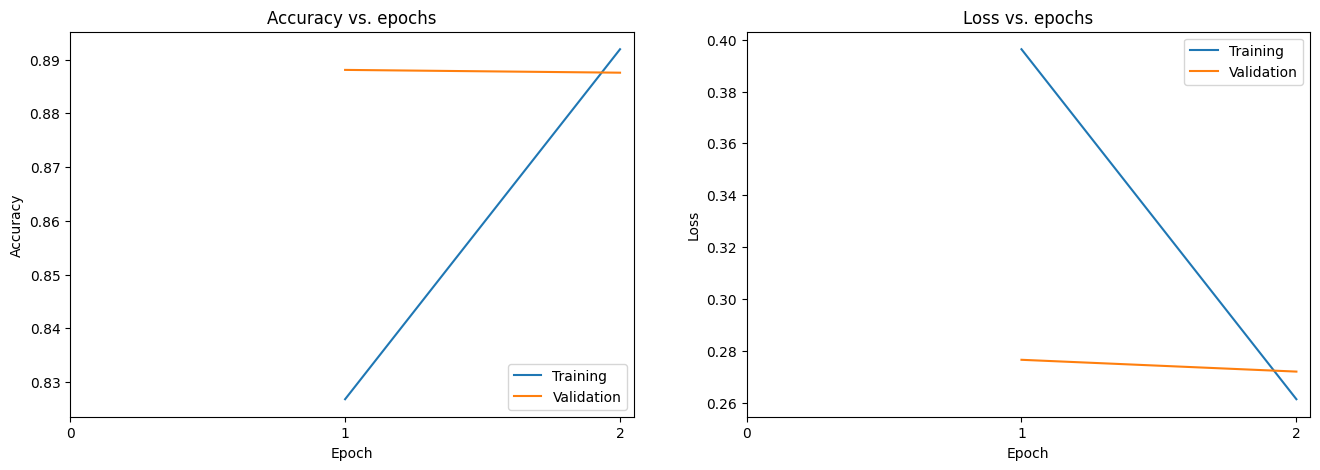

2021-12-06 06:21:21,872: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1
----------------------------------------evaluate----------------------------------------


2021-12-06 06:22:20,133: INFO: test loss:0.2765
2021-12-06 06:22:20,134: INFO: test accuracy:0.8881
2021-12-06 06:22:20,135: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2021-12-06 06:22:20,137: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2021-12-06 06:22:20,138: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_preproess.generator


----------------------------------------save model results and generator----------------------------------------


2021-12-06 06:22:20,810: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_preproess.generator


----------------------------------------confusion matrix----------------------------------------


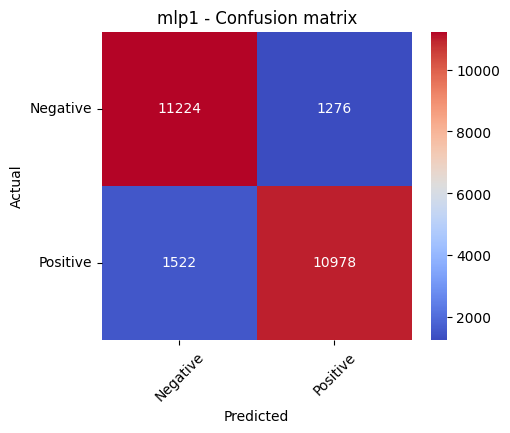

----------------------------------------sample analysis----------------------------------------
<class 'list'>
----------------------------------------1. Positive----------------------------------------
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


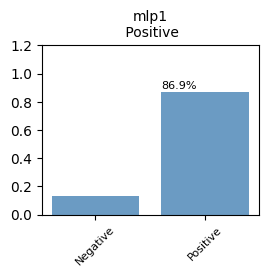

----------------------------------------2. Negative----------------------------------------
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


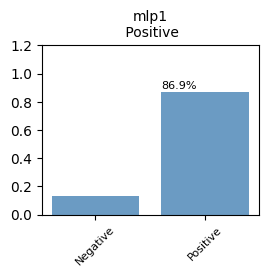

----------------------------------------3. Negative----------------------------------------
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


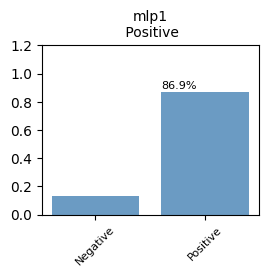

----------------------------------------4. Positive----------------------------------------
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


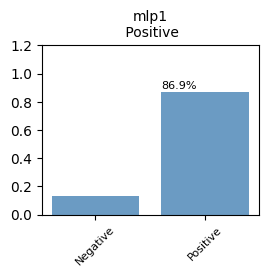

----------------------------------------5. Positive----------------------------------------
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


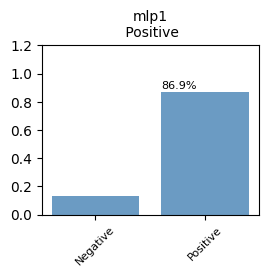

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,mlp1,imdb_0721_p100.ipynb,5120770,10.9,2021-12-06 06:22,0.1834,0.2765,0.939,0.8881,0.9848,0.9558


In [26]:
helper = qtf.classification.Classification(params, datasets=ngram_datasets1, model_results=model_results)
model = qtf.classification.text_models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True)

#### mlp2

2021-12-06 06:22:49,584: INFO: model_params.mlp2.dropout=0.6
2021-12-06 06:22:49,584: INFO: model_params.mlp2.layer_count=1
2021-12-06 06:22:49,585: INFO: model_params.mlp2.units=256
2021-12-06 06:22:49,605: INFO: output_bias=[-0.69314718 -0.69314718]
2021-12-06 06:22:49,613: INFO: learning_rate=0.001
2021-12-06 06:22:49,614: INFO: model_params.mlp2.clip_value=None
2021-12-06 06:22:49,619: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2
2021-12-06 06:22:49,621: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2, monitor=val_accuracy)
2021-12-06 06:22:49,622: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-12-06 06:22:49,623: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-12-06 06:22:49,623: INFO: use LearningRateScheduler()
2021-12-06 06:22:49,624: 

TensorSpec(shape=(32, 20000), dtype=tf.float32, name=None)
Model: "mlp2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dropout_2 (Dropout)         (None, 20000)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               5120256   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 5,120,770
Trainable params: 5,120,770
Non-trainable params: 0
___________________________________________________________

2021-12-06 06:23:17,304: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2/assets


781/781 [==============================] - 28s 35ms/step - loss: 0.9078 - accuracy: 0.7587 - val_loss: 0.4037 - val_accuracy: 0.8613 - lr: 0.0010
Epoch 2/2
776/781 [============================>.] - ETA: 0s - loss: 0.4022 - accuracy: 0.8336INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2/assets


2021-12-06 06:23:22,533: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2/assets


781/781 [==============================] - 5s 7ms/step - loss: 0.4022 - accuracy: 0.8336 - val_loss: 0.3481 - val_accuracy: 0.8871 - lr: 0.0010


2021-12-06 06:23:22,561: INFO: finish training [elapsed time: 32.94 seconds]


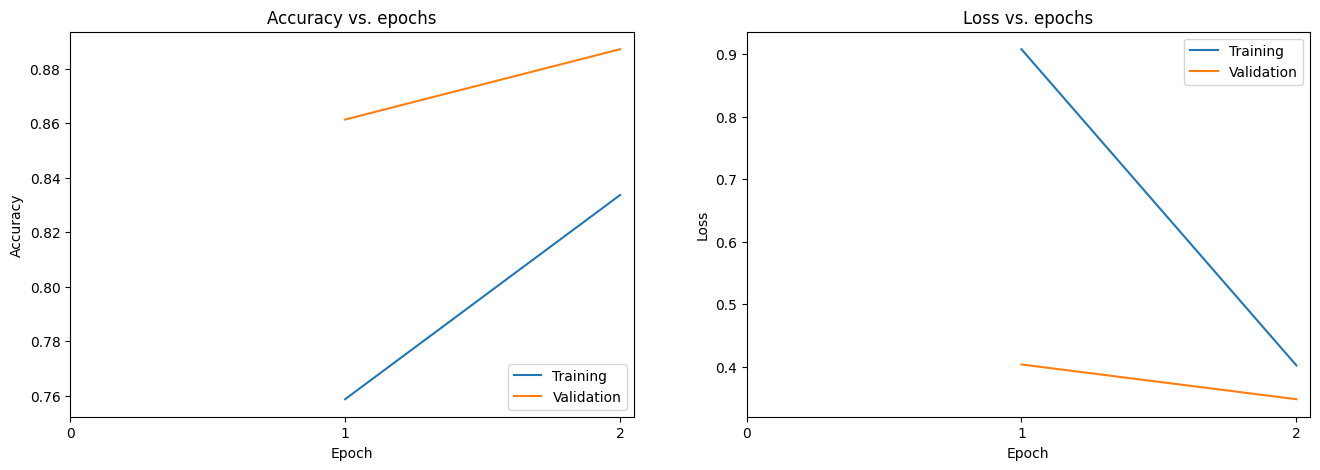

2021-12-06 06:23:22,984: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2
----------------------------------------evaluate----------------------------------------


2021-12-06 06:24:16,429: INFO: test loss:0.3481
2021-12-06 06:24:16,430: INFO: test accuracy:0.8871
2021-12-06 06:24:16,431: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2021-12-06 06:24:16,432: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2021-12-06 06:24:16,433: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_map.generator
2021-12-06 06:24:16,480: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_map.pkl
2021-12-06 06:24:16,482: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_map.generator
2021-12-06 06:24:16,483: INFO: loading model fro

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-12-06 06:24:16,951: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_preproess.generator


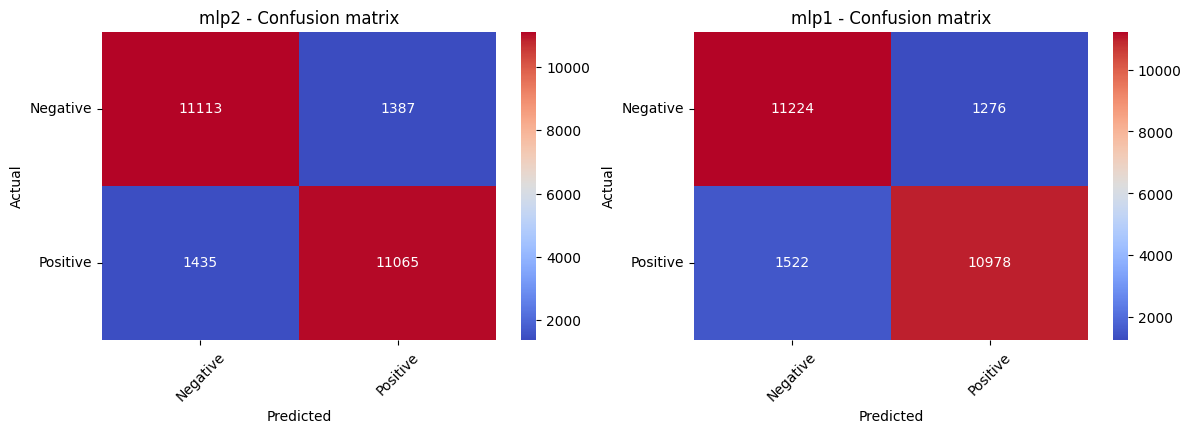

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,mlp1,imdb_0721_p100.ipynb,5120770,10.9,2021-12-06 06:22,0.1834,0.2765,0.9390,0.8881,0.9848,0.9558
2,mlp2,imdb_0721_p100.ipynb,5120770,32.9,2021-12-06 06:24,0.2824,0.3481,0.9306,0.8871,0.9809,0.9529


In [27]:
helper = qtf.classification.Classification(params, datasets=ngram_datasets2, model_results=model_results)
model = qtf.classification.text_models.mlp1(helper, name='mlp2')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### Embedding

#### embedding1

2021-12-06 06:27:35,162: INFO: model_params.embedding1.dropout=0.4
2021-12-06 06:27:35,163: INFO: model_params.embedding1.embedding_dim=200
2021-12-06 06:27:35,195: INFO: output_bias=[-0.69314718 -0.69314718]
2021-12-06 06:27:35,204: INFO: learning_rate=0.001
2021-12-06 06:27:35,205: INFO: model_params.embedding1.clip_value=None
2021-12-06 06:27:35,212: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding1
2021-12-06 06:27:35,221: INFO: model_params.embedding1.epochs=15
2021-12-06 06:27:35,222: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding1, monitor=val_accuracy)
2021-12-06 06:27:35,223: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-12-06 06:27:35,223: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-12-06 06:27:35,224: INFO: use LearningR

TensorSpec(shape=(32, 500), dtype=tf.int32, name=None)
Model: "embedding1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 500, 200)     4000000     ['input_3[0][0]']                
                                                                                                  
 global_average_pooling1d (Glob  (None, 200)         0           ['embedding[0][0]']              
 alAveragePooling1D)                                                                              
                                                                                                  
 global_max_pooling1d (GlobalMa  (

2021-12-06 06:27:49,224: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding1/assets


781/781 [==============================] - 14s 17ms/step - loss: 0.4231 - accuracy: 0.8176 - val_loss: 0.3103 - val_accuracy: 0.8703 - lr: 0.0010
Epoch 2/15
779/781 [============================>.] - ETA: 0s - loss: 0.2310 - accuracy: 0.9111INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding1/assets


2021-12-06 06:28:03,829: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding1/assets


781/781 [==============================] - 15s 19ms/step - loss: 0.2307 - accuracy: 0.9112 - val_loss: 0.2761 - val_accuracy: 0.8838 - lr: 0.0010
Epoch 3/15
781/781 [==============================] - 9s 11ms/step - loss: 0.1486 - accuracy: 0.9495 - val_loss: 0.2799 - val_accuracy: 0.8835 - lr: 0.0010
Epoch 4/15
781/781 [==============================] - 8s 10ms/step - loss: 0.0929 - accuracy: 0.9725 - val_loss: 0.3031 - val_accuracy: 0.8773 - lr: 0.0010
Epoch 5/15
781/781 [==============================] - 11s 14ms/step - loss: 0.0554 - accuracy: 0.9866 - val_loss: 0.3424 - val_accuracy: 0.8693 - lr: 0.0010
Epoch 6/15
781/781 [==============================] - 9s 12ms/step - loss: 0.0312 - accuracy: 0.9944 - val_loss: 0.3862 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 7/15
781/781 [==============================] - 27s 35ms/step - loss: 0.0168 - accuracy: 0.9982 - val_loss: 0.4224 - val_accuracy: 0.8584 - lr: 0.0010
Epoch 8/15
781/781 [==============================] - 19s 25ms/step - lo

2021-12-06 06:34:01,263: INFO: finish training [elapsed time: 386.04 seconds]


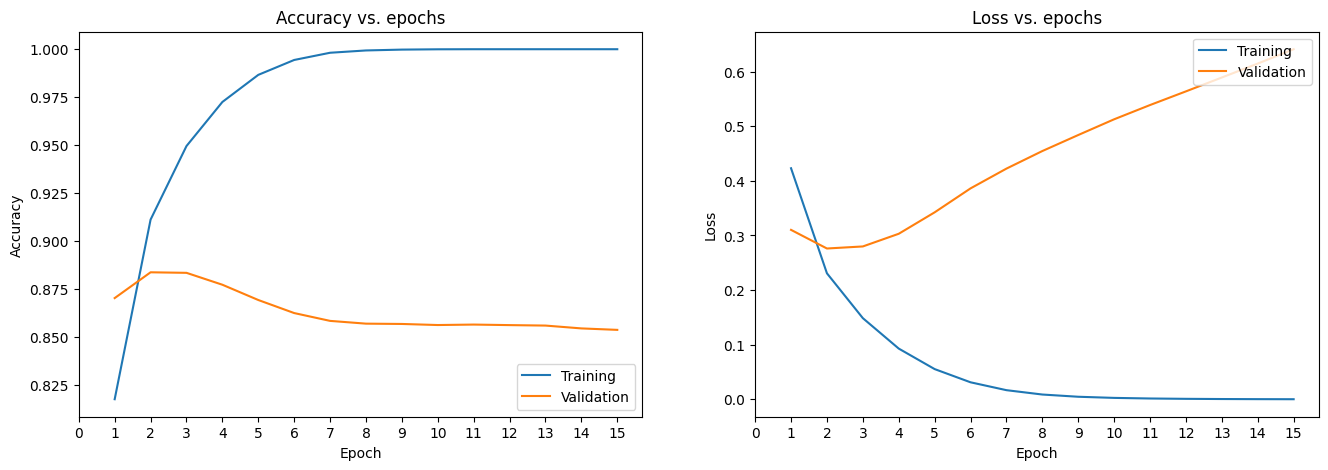

2021-12-06 06:34:01,784: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding1
----------------------------------------evaluate----------------------------------------


2021-12-06 06:35:13,467: INFO: test loss:0.2761
2021-12-06 06:35:13,468: INFO: test accuracy:0.8838
2021-12-06 06:35:13,470: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2021-12-06 06:35:13,472: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2021-12-06 06:35:13,473: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_prepross.generator
2021-12-06 06:35:13,590: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_prepross.generator
2021-12-06 06:35:13,591: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-12-06 06:35:14,062: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_preproess.generator


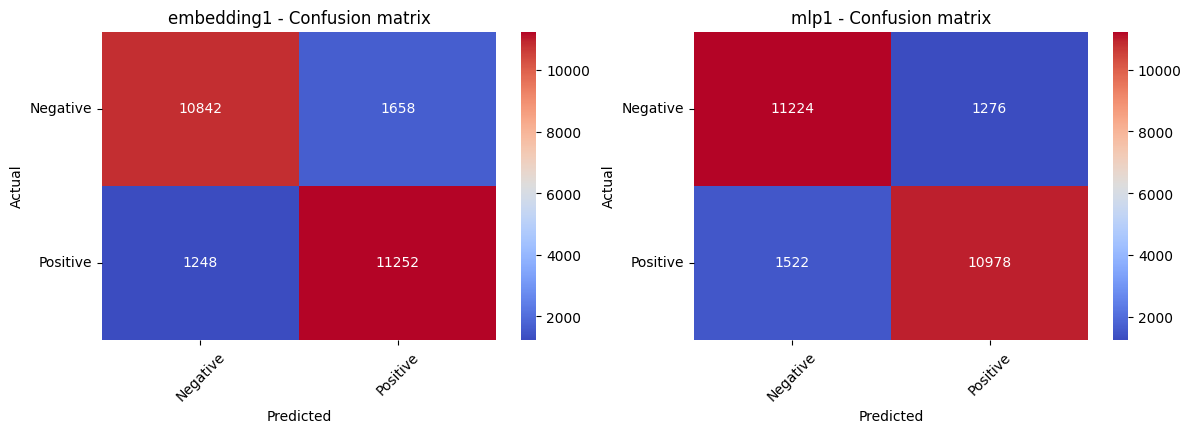

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,mlp1,imdb_0721_p100.ipynb,5120770,10.9,2021-12-06 06:22,0.1834,0.2765,0.9390,0.8881,0.9848,0.9558
2,mlp2,imdb_0721_p100.ipynb,5120770,32.9,2021-12-06 06:24,0.2824,0.3481,0.9306,0.8871,0.9809,0.9529
3,embedding1,imdb_0721_p100.ipynb,4000802,386.0,2021-12-06 06:35,0.1578,0.2761,0.9481,0.8838,0.9884,0.9541


In [29]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets1)
model = qtf.classification.text_models.embedding1(helper, name='embedding1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### embedding2

2021-12-06 06:36:00,141: INFO: model_params.embedding2.dropout=0.4
2021-12-06 06:36:00,143: INFO: model_params.embedding2.embedding_dim=200
2021-12-06 06:36:00,167: INFO: output_bias=[-0.69314718 -0.69314718]
2021-12-06 06:36:00,179: INFO: learning_rate=0.001
2021-12-06 06:36:00,180: INFO: model_params.embedding2.clip_value=None
2021-12-06 06:36:00,186: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding2
2021-12-06 06:36:00,189: INFO: model_params.embedding2.epochs=15
2021-12-06 06:36:00,191: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding2, monitor=val_accuracy)
2021-12-06 06:36:00,191: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-12-06 06:36:00,192: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-12-06 06:36:00,193: INFO: use LearningR

TensorSpec(shape=(32, 500), dtype=tf.int64, name=None)
Model: "embedding2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 500, 200)     4000000     ['input_4[0][0]']                
                                                                                                  
 global_average_pooling1d_1 (Gl  (None, 200)         0           ['embedding_1[0][0]']            
 obalAveragePooling1D)                                                                            
                                                                                                  
 global_max_pooling1d_1 (Global  (

2021-12-06 06:36:24,874: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding2/assets


781/781 [==============================] - 25s 31ms/step - loss: 0.4281 - accuracy: 0.8117 - val_loss: 0.3101 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 2/15
781/781 [==============================] - ETA: 0s - loss: 0.2417 - accuracy: 0.9060INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding2/assets


2021-12-06 06:36:56,151: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding2/assets


781/781 [==============================] - 31s 40ms/step - loss: 0.2417 - accuracy: 0.9060 - val_loss: 0.2790 - val_accuracy: 0.8830 - lr: 0.0010
Epoch 3/15
781/781 [==============================] - 34s 44ms/step - loss: 0.1657 - accuracy: 0.9403 - val_loss: 0.2818 - val_accuracy: 0.8829 - lr: 0.0010
Epoch 4/15
781/781 [==============================] - 8s 10ms/step - loss: 0.1123 - accuracy: 0.9640 - val_loss: 0.3017 - val_accuracy: 0.8773 - lr: 0.0010
Epoch 5/15
781/781 [==============================] - 10s 13ms/step - loss: 0.0735 - accuracy: 0.9798 - val_loss: 0.3330 - val_accuracy: 0.8722 - lr: 0.0010
Epoch 6/15
781/781 [==============================] - 30s 38ms/step - loss: 0.0461 - accuracy: 0.9900 - val_loss: 0.3702 - val_accuracy: 0.8644 - lr: 0.0010
Epoch 7/15
781/781 [==============================] - 29s 37ms/step - loss: 0.0274 - accuracy: 0.9958 - val_loss: 0.4088 - val_accuracy: 0.8603 - lr: 0.0010
Epoch 8/15
781/781 [==============================] - 9s 12ms/step - l

2021-12-06 06:42:48,813: INFO: finish training [elapsed time: 408.62 seconds]


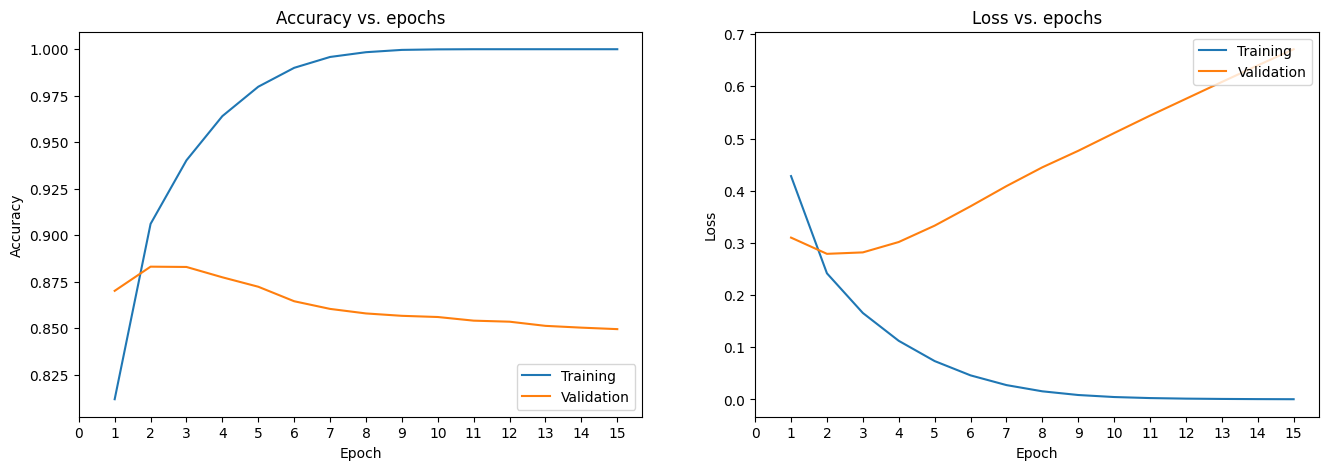

2021-12-06 06:42:49,285: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding2
----------------------------------------evaluate----------------------------------------


2021-12-06 06:43:44,027: INFO: test loss:0.2790
2021-12-06 06:43:44,028: INFO: test accuracy:0.8830
2021-12-06 06:43:44,029: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2021-12-06 06:43:44,031: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2021-12-06 06:43:44,032: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2021-12-06 06:43:44,089: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.pkl
2021-12-06 06:43:44,091: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2021-12-06 06:43:44,091: INFO: loading 

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-12-06 06:43:44,995: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_preproess.generator


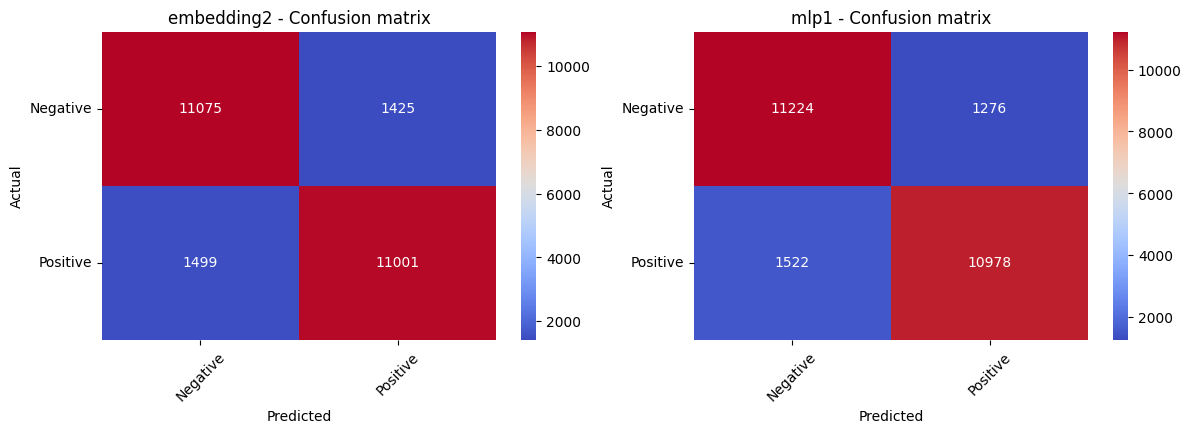

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,mlp1,imdb_0721_p100.ipynb,5120770,10.9,2021-12-06 06:22,0.1834,0.2765,0.9390,0.8881,0.9848,0.9558
2,mlp2,imdb_0721_p100.ipynb,5120770,32.9,2021-12-06 06:24,0.2824,0.3481,0.9306,0.8871,0.9809,0.9529
3,embedding1,imdb_0721_p100.ipynb,4000802,386.0,2021-12-06 06:35,0.1578,0.2761,0.9481,0.8838,0.9884,0.9541
4,embedding2,imdb_0721_p100.ipynb,4000802,408.6,2021-12-06 06:43,0.1683,0.2790,0.9431,0.8830,0.9857,0.9526


In [30]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.embedding1(helper, name='embedding2')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### sepCNN

#### sepcnn

In [31]:
# helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
# model = qtf.classification.models.sepcnn1(helper, name='sepcnn', blocks=1)
# # when bolcks=2, the model can't converg
# model.summary()
# history = helper.train(model)
# helper.model_summary(model, history=history)

#### sepcnn_fasttext

In [32]:
# helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
# model = qtf.classification.models.sepcnn1(helper, name='sepcnn_ft', blocks=1, 
#                    embedding_matrix=embedding_matrix_fasttext,
#                    is_embedding_trainable=False)
# model.summary()
# history = helper.train(model)
# helper.model_summary(model, history=history)

### LSTM

#### rnn_lstm

2021-12-06 07:09:44,470: INFO: model_params.rnn_lstm.dropout=0.4
2021-12-06 07:09:44,471: INFO: model_params.rnn_lstm.units=200
2021-12-06 07:09:44,471: INFO: max_features=20000
2021-12-06 07:09:44,472: INFO: model_params.rnn_lstm.embedding_dim=200


TensorSpec(shape=(32, 500), dtype=tf.int64, name=None)


2021-12-06 07:09:45,398: INFO: output_bias=[-0.69314718 -0.69314718]
2021-12-06 07:09:45,411: INFO: learning_rate=0.001
2021-12-06 07:09:45,411: INFO: model_params.rnn_lstm.clip_value=None
2021-12-06 07:09:45,418: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm
2021-12-06 07:09:45,421: INFO: model_params.rnn_lstm.epochs=5
2021-12-06 07:09:45,422: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm, monitor=val_accuracy)
2021-12-06 07:09:45,423: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-12-06 07:09:45,423: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-12-06 07:09:45,424: INFO: use LearningRateScheduler()
2021-12-06 07:09:45,424: INFO: steps_per_epoch=None
2021-12-06 07:09:45,425: INFO: start training
2021-12-06 07:09:45,425: INFO: use_c

Model: "rnn_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 500, 200)          4000200   
                                                                 
 bidirectional (Bidirectiona  (None, 500, 400)         641600    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 200)               480800    
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 2)                 402       
                                                          

2021-12-06 07:16:16,705: WARNING: Found untraced functions such as lstm_cell_3_layer_call_fn, lstm_cell_3_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm/assets


2021-12-06 07:16:20,409: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm/assets
2021-12-06 07:16:20,918: WARNING: <keras.layers.recurrent.LSTMCell object at 0x7fb0a4dfe910> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2021-12-06 07:16:20,919: WARNING: <keras.layers.recurrent.LSTMCell object at 0x7fafa420f910> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2021-12-06 07:16:20,921: WARNING: <keras.layers.recurrent.

781/781 [==============================] - 395s 500ms/step - loss: 0.6941 - accuracy: 0.5025 - val_loss: 0.6920 - val_accuracy: 0.5092 - lr: 0.0010
Epoch 2/5
781/781 [==============================] - 313s 402ms/step - loss: 0.6969 - accuracy: 0.5120 - val_loss: 0.6975 - val_accuracy: 0.5074 - lr: 0.0010
Epoch 3/5
781/781 [==============================] - 351s 449ms/step - loss: 0.6835 - accuracy: 0.5292 - val_loss: 0.7026 - val_accuracy: 0.5045 - lr: 0.0010
Epoch 4/5
781/781 [==============================] - 180s 230ms/step - loss: 0.6759 - accuracy: 0.5212 - val_loss: 0.7054 - val_accuracy: 0.5056 - lr: 0.0010
Epoch 5/5
781/781 [==============================] - 317s 406ms/step - loss: 0.6686 - accuracy: 0.5276 - val_loss: 0.7166 - val_accuracy: 0.5024 - lr: 0.0010


2021-12-06 07:35:42,154: INFO: finish training [elapsed time: 1556.73 seconds]


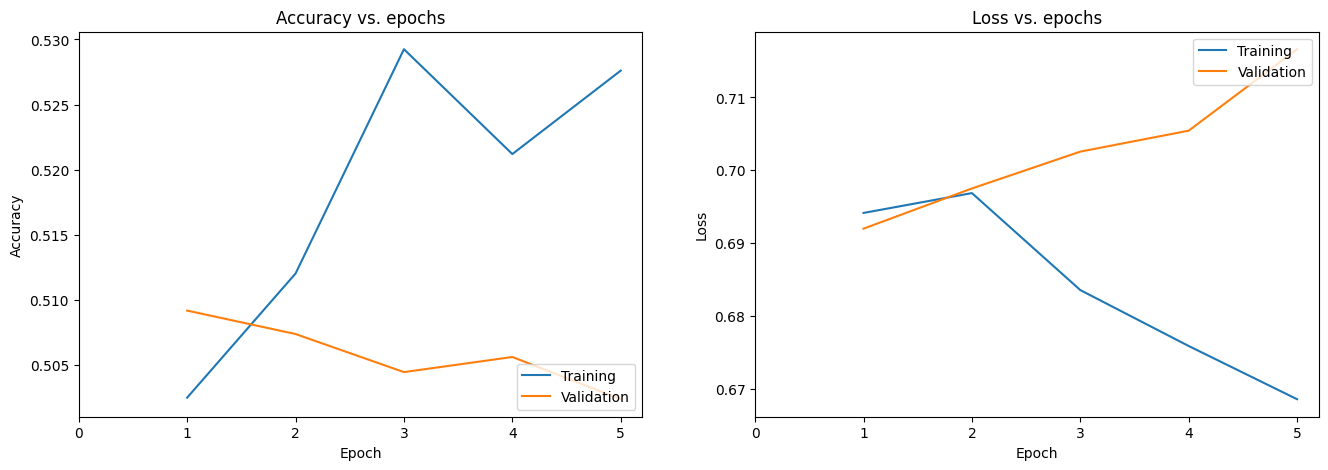

2021-12-06 07:35:42,486: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm
----------------------------------------evaluate----------------------------------------


2021-12-06 07:39:43,088: INFO: test loss:0.6920
2021-12-06 07:39:43,089: INFO: test accuracy:0.5092
2021-12-06 07:39:43,091: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2021-12-06 07:39:43,093: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2021-12-06 07:39:43,093: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2021-12-06 07:39:43,144: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.pkl
2021-12-06 07:39:43,146: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2021-12-06 07:39:43,146: INFO: loading 

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-12-06 07:39:43,591: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_preproess.generator


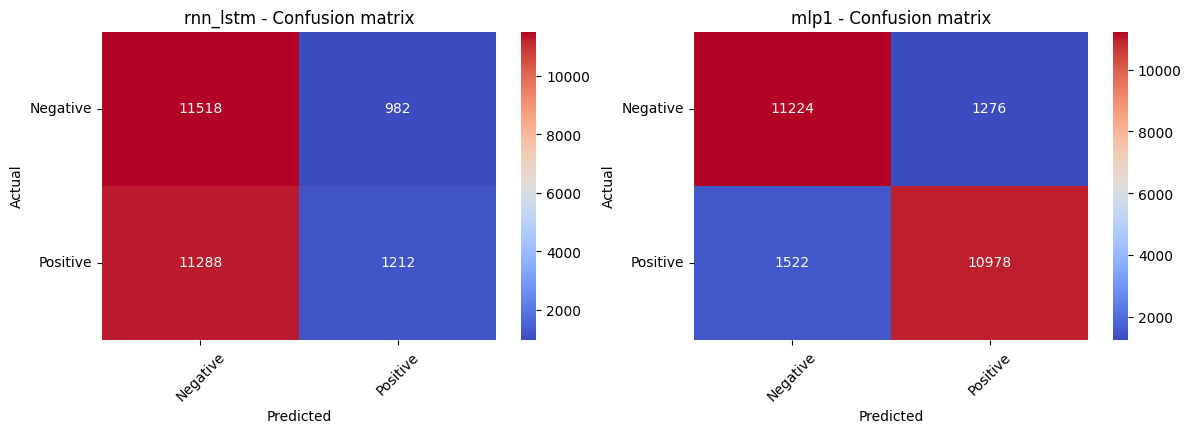

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,mlp1,imdb_0721_p100.ipynb,5120770,10.9,2021-12-06 06:22,0.1834,0.2765,0.9390,0.8881,0.9848,0.9558
2,mlp2,imdb_0721_p100.ipynb,5120770,32.9,2021-12-06 06:24,0.2824,0.3481,0.9306,0.8871,0.9809,0.9529
3,embedding1,imdb_0721_p100.ipynb,4000802,386.0,2021-12-06 06:35,0.1578,0.2761,0.9481,0.8838,0.9884,0.9541
4,embedding2,imdb_0721_p100.ipynb,4000802,408.6,2021-12-06 06:43,0.1683,0.2790,0.9431,0.8830,0.9857,0.9526
5,rnn_lstm,imdb_0721_p100.ipynb,5123002,1556.7,2021-12-06 07:39,0.6893,0.6920,0.5247,0.5092,0.5337,0.5157


In [34]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.lstm1(helper, name='rnn_lstm')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### rnn_lstm_fasttext

2021-12-06 07:41:07,612: INFO: model_params.rnn_lstm_ft.dropout=0.4
2021-12-06 07:41:07,613: INFO: model_params.rnn_lstm_ft.units=200
2021-12-06 07:41:07,613: INFO: max_features=20000
2021-12-06 07:41:07,614: INFO: model_params.rnn_lstm_ft.embedding_dim=200


TensorSpec(shape=(32, 500), dtype=tf.int64, name=None)
19776 300


2021-12-06 07:41:08,517: INFO: output_bias=[-0.69314718 -0.69314718]
2021-12-06 07:41:08,525: INFO: learning_rate=0.001
2021-12-06 07:41:08,526: INFO: model_params.rnn_lstm_ft.clip_value=None
2021-12-06 07:41:08,532: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm_ft
2021-12-06 07:41:08,544: INFO: model_params.rnn_lstm_ft.epochs=5
2021-12-06 07:41:08,545: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm_ft, monitor=val_accuracy)
2021-12-06 07:41:08,545: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-12-06 07:41:08,546: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-12-06 07:41:08,546: INFO: use LearningRateScheduler()
2021-12-06 07:41:08,547: INFO: steps_per_epoch=None
2021-12-06 07:41:08,547: INFO: start training
2021-12-06 07:41:08,548:

Model: "rnn_lstm_ft"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 500, 300)          5932800   
                                                                 
 bidirectional_1 (Bidirectio  (None, 500, 400)         801600    
 nal)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 200)               480800    
                                                                 
 dropout_5 (Dropout)         (None, 200)               0         
                                                                 
 dense_7 (Dense)             (None, 2)                 402       
                                                       

2021-12-06 07:46:20,676: WARNING: Found untraced functions such as lstm_cell_11_layer_call_fn, lstm_cell_11_layer_call_and_return_conditional_losses, lstm_cell_9_layer_call_fn, lstm_cell_9_layer_call_and_return_conditional_losses, lstm_cell_10_layer_call_fn while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm_ft/assets


2021-12-06 07:46:24,569: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm_ft/assets
2021-12-06 07:46:25,025: WARNING: <keras.layers.recurrent.LSTMCell object at 0x7fb0a6b85160> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2021-12-06 07:46:25,026: WARNING: <keras.layers.recurrent.LSTMCell object at 0x7fb0a7dba040> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2021-12-06 07:46:25,027: WARNING: <keras.layers.recurre

781/781 [==============================] - 316s 400ms/step - loss: 0.6805 - accuracy: 0.5487 - val_loss: 0.6379 - val_accuracy: 0.6656 - lr: 0.0010
Epoch 2/5
781/781 [==============================] - 284s 364ms/step - loss: 0.6832 - accuracy: 0.5364 - val_loss: 0.6916 - val_accuracy: 0.5102 - lr: 0.0010
Epoch 3/5
781/781 [==============================] - 359s 459ms/step - loss: 0.6890 - accuracy: 0.5192 - val_loss: 0.6910 - val_accuracy: 0.5118 - lr: 0.0010
Epoch 4/5
781/781 [==============================] - 385s 494ms/step - loss: 0.6872 - accuracy: 0.5190 - val_loss: 0.6901 - val_accuracy: 0.5105 - lr: 0.0010
Epoch 5/5
781/781 [==============================] - 395s 506ms/step - loss: 0.6797 - accuracy: 0.5463 - val_loss: 0.6915 - val_accuracy: 0.5072 - lr: 0.0010


2021-12-06 08:10:08,360: INFO: finish training [elapsed time: 1739.81 seconds]


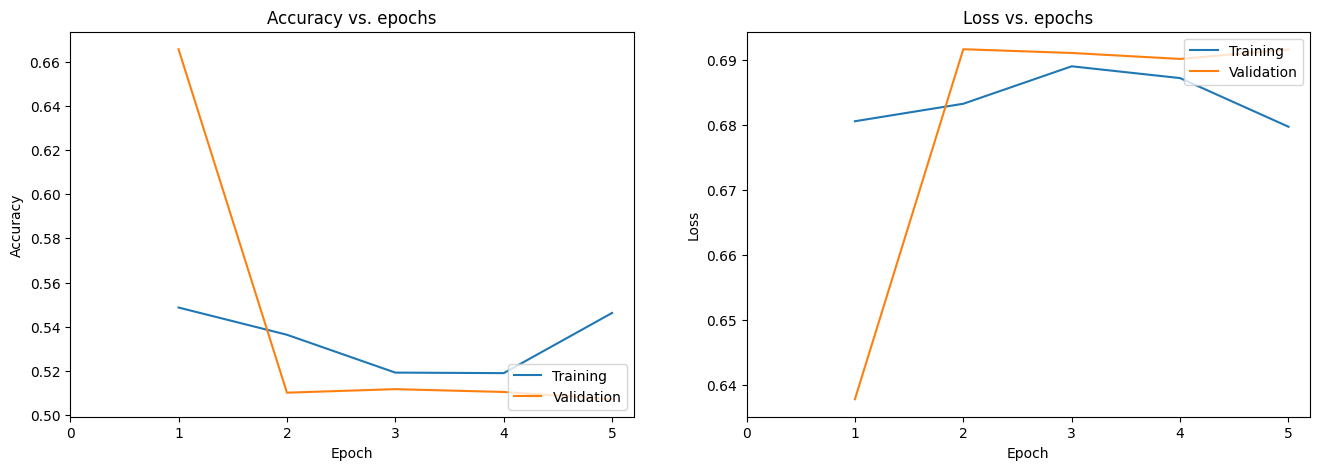

2021-12-06 08:10:08,742: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm_ft


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm_ft
----------------------------------------evaluate----------------------------------------


2021-12-06 08:16:52,047: INFO: test loss:0.6379
2021-12-06 08:16:52,048: INFO: test accuracy:0.6656
2021-12-06 08:16:52,049: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2021-12-06 08:16:52,051: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2021-12-06 08:16:52,051: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2021-12-06 08:16:52,111: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.pkl
2021-12-06 08:16:52,113: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2021-12-06 08:16:52,113: INFO: loading 

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-12-06 08:16:52,595: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_preproess.generator


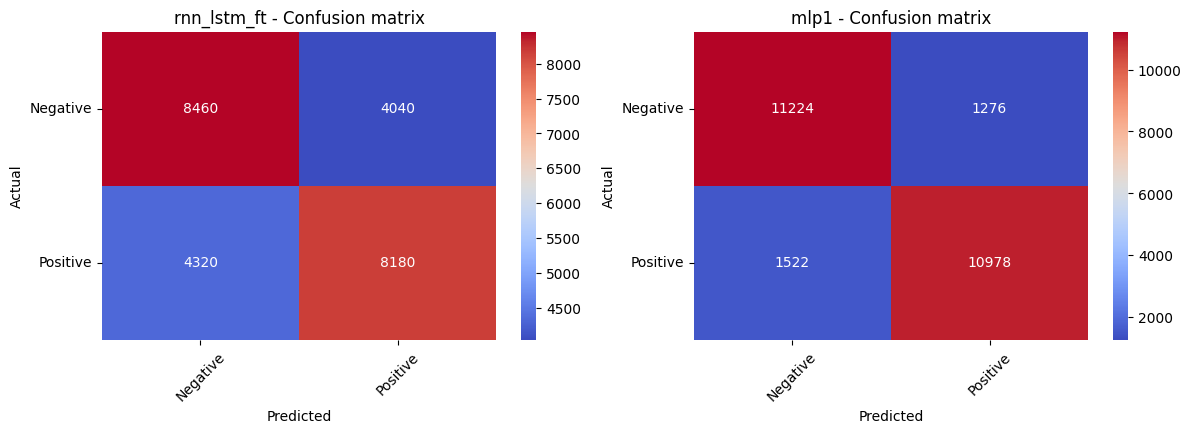

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,mlp1,imdb_0721_p100.ipynb,5120770,10.9,2021-12-06 06:22,0.1834,0.2765,0.9390,0.8881,0.9848,0.9558
2,mlp2,imdb_0721_p100.ipynb,5120770,32.9,2021-12-06 06:24,0.2824,0.3481,0.9306,0.8871,0.9809,0.9529
3,embedding1,imdb_0721_p100.ipynb,4000802,386.0,2021-12-06 06:35,0.1578,0.2761,0.9481,0.8838,0.9884,0.9541
4,embedding2,imdb_0721_p100.ipynb,4000802,408.6,2021-12-06 06:43,0.1683,0.2790,0.9431,0.8830,0.9857,0.9526
5,rnn_lstm_ft,imdb_0721_p100.ipynb,1282802,1739.8,2021-12-06 08:16,0.6313,0.6379,0.6742,0.6656,0.6906,0.6791
6,rnn_lstm,imdb_0721_p100.ipynb,5123002,1556.7,2021-12-06 07:39,0.6893,0.6920,0.5247,0.5092,0.5337,0.5157


In [35]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.lstm1(helper, name='rnn_lstm_ft',
                 embedding_matrix=embedding_matrix_fasttext,
                 is_embedding_trainable=False,
                 mask_zero=False)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### Pooled GRU 

#### pg_default

2021-12-06 08:18:47,042: INFO: model_params.pg_default.dropout=0.4
2021-12-06 08:18:47,043: INFO: model_params.pg_default.learning_rate=0.0005
2021-12-06 08:18:47,044: INFO: model_params.pg_default.clip_value=None
2021-12-06 08:18:47,045: INFO: batch_size=32
2021-12-06 08:18:47,045: INFO: max_features=20000
2021-12-06 08:18:47,046: INFO: model_params.pg_default.embedding_dim=300
2021-12-06 08:18:47,614: INFO: output_bias=[-0.69314718 -0.69314718]
2021-12-06 08:18:47,626: INFO: model_params.pg_default.clip_value=None
2021-12-06 08:18:47,632: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_default
2021-12-06 08:18:47,637: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_default, monitor=val_accuracy)
2021-12-06 08:18:47,637: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-12-06 08:18:47,638: INFO:

Model: "pg_default"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 500, 300)     6000000     ['input_7[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 500, 300)    0           ['embedding_4[0][0]']            
 out1D)                                                                                           
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 500, 160)    183360      ['spatial_dropout1d[0][0

2021-12-06 08:21:44,673: WARNING: Found untraced functions such as gru_cell_1_layer_call_fn, gru_cell_1_layer_call_and_return_conditional_losses, gru_cell_2_layer_call_fn, gru_cell_2_layer_call_and_return_conditional_losses, gru_cell_1_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_default/assets


2021-12-06 08:21:47,806: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_default/assets
2021-12-06 08:21:48,130: WARNING: <keras.layers.recurrent.GRUCell object at 0x7faf84fb75e0> has the same name 'GRUCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.GRUCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2021-12-06 08:21:48,132: WARNING: <keras.layers.recurrent.GRUCell object at 0x7faf84f7c3d0> has the same name 'GRUCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.GRUCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.


781/781 [==============================] - 180s 227ms/step - loss: 0.4126 - accuracy: 0.8014 - val_loss: 0.2938 - val_accuracy: 0.8744 - lr: 5.0000e-04


2021-12-06 08:21:48,148: INFO: finish training [elapsed time: 180.51 seconds]


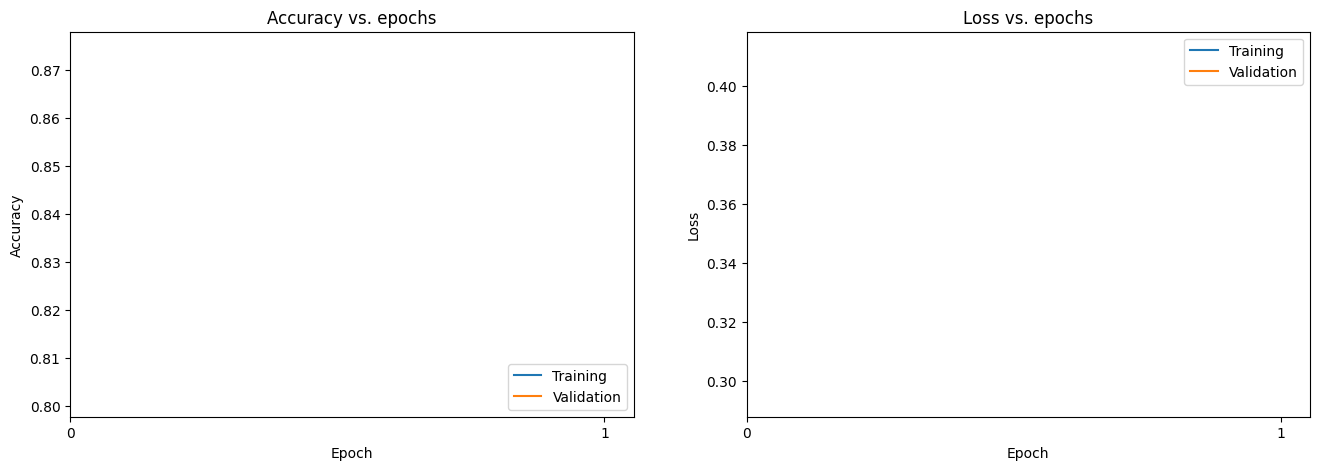

2021-12-06 08:21:48,483: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_default


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_default
----------------------------------------evaluate----------------------------------------


2021-12-06 08:25:13,218: INFO: test loss:0.2938
2021-12-06 08:25:13,218: INFO: test accuracy:0.8744
2021-12-06 08:25:13,220: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2021-12-06 08:25:13,221: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2021-12-06 08:25:13,222: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2021-12-06 08:25:13,284: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.pkl
2021-12-06 08:25:13,285: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2021-12-06 08:25:13,286: INFO: loading 

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-12-06 08:25:13,816: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_preproess.generator


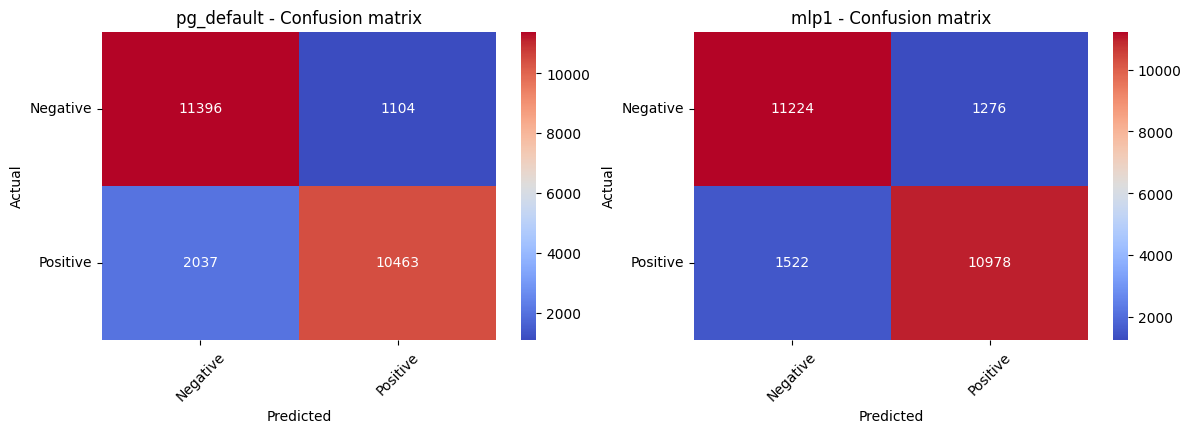

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,mlp1,imdb_0721_p100.ipynb,5120770,10.9,2021-12-06 06:22,0.1834,0.2765,0.9390,0.8881,0.9848,0.9558
2,mlp2,imdb_0721_p100.ipynb,5120770,32.9,2021-12-06 06:24,0.2824,0.3481,0.9306,0.8871,0.9809,0.9529
3,embedding1,imdb_0721_p100.ipynb,4000802,386.0,2021-12-06 06:35,0.1578,0.2761,0.9481,0.8838,0.9884,0.9541
4,embedding2,imdb_0721_p100.ipynb,4000802,408.6,2021-12-06 06:43,0.1683,0.2790,0.9431,0.8830,0.9857,0.9526
5,pg_default,imdb_0721_p100.ipynb,6184002,180.5,2021-12-06 08:25,0.2114,0.2938,0.9194,0.8744,0.9762,0.9507
6,rnn_lstm_ft,imdb_0721_p100.ipynb,1282802,1739.8,2021-12-06 08:16,0.6313,0.6379,0.6742,0.6656,0.6906,0.6791
7,rnn_lstm,imdb_0721_p100.ipynb,5123002,1556.7,2021-12-06 07:39,0.6893,0.6920,0.5247,0.5092,0.5337,0.5157


In [36]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.pooled_gru1(helper, name='pg_default')
model.summary()
history = helper.train(model) 
helper.model_summary(model, history=history)

#### pg_fasttext

2021-12-06 08:26:26,571: INFO: model_params.pg_ft.dropout=0.4
2021-12-06 08:26:26,572: INFO: model_params.pg_ft.learning_rate=0.0005
2021-12-06 08:26:26,573: INFO: model_params.pg_ft.clip_value=None
2021-12-06 08:26:26,574: INFO: batch_size=32
2021-12-06 08:26:26,574: INFO: max_features=20000
2021-12-06 08:26:26,575: INFO: model_params.pg_ft.embedding_dim=300
2021-12-06 08:26:27,126: INFO: output_bias=[-0.69314718 -0.69314718]
2021-12-06 08:26:27,139: INFO: model_params.pg_ft.clip_value=None
2021-12-06 08:26:27,146: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft
2021-12-06 08:26:27,150: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft, monitor=val_accuracy)
2021-12-06 08:26:27,151: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-12-06 08:26:27,152: INFO: use ReduceLROnPlateau(monitor=val_

Model: "pg_ft"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 500, 300)     5932800     ['input_8[0][0]']                
                                                                                                  
 spatial_dropout1d_1 (SpatialDr  (None, 500, 300)    0           ['embedding_5[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 500, 160)    183360      ['spatial_dropout1d_1[0][0]']

2021-12-06 08:28:58,414: WARNING: Found untraced functions such as gru_cell_7_layer_call_fn, gru_cell_7_layer_call_and_return_conditional_losses, gru_cell_8_layer_call_fn, gru_cell_8_layer_call_and_return_conditional_losses, gru_cell_7_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft/assets


2021-12-06 08:29:00,589: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft/assets
2021-12-06 08:29:00,913: WARNING: <keras.layers.recurrent.GRUCell object at 0x7faf6720ca30> has the same name 'GRUCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.GRUCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2021-12-06 08:29:00,914: WARNING: <keras.layers.recurrent.GRUCell object at 0x7faf42cf6190> has the same name 'GRUCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.GRUCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.


781/781 [==============================] - 154s 193ms/step - loss: 0.4336 - accuracy: 0.7949 - val_loss: 0.2959 - val_accuracy: 0.8742 - lr: 5.0000e-04
Epoch 00002: Still keep learning rate 0.0005 instead of 0.001
Epoch 2/2
781/781 [==============================] - ETA: 0s - loss: 0.3217 - accuracy: 0.8626

2021-12-06 08:31:23,041: WARNING: Found untraced functions such as gru_cell_7_layer_call_fn, gru_cell_7_layer_call_and_return_conditional_losses, gru_cell_8_layer_call_fn, gru_cell_8_layer_call_and_return_conditional_losses, gru_cell_7_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft/assets


2021-12-06 08:31:25,322: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft/assets
2021-12-06 08:31:25,692: WARNING: <keras.layers.recurrent.GRUCell object at 0x7faf6720ca30> has the same name 'GRUCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.GRUCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2021-12-06 08:31:25,693: WARNING: <keras.layers.recurrent.GRUCell object at 0x7faf42cf6190> has the same name 'GRUCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.GRUCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.


781/781 [==============================] - 145s 185ms/step - loss: 0.3217 - accuracy: 0.8626 - val_loss: 0.2725 - val_accuracy: 0.8851 - lr: 5.0000e-04


2021-12-06 08:31:25,713: INFO: finish training [elapsed time: 298.56 seconds]


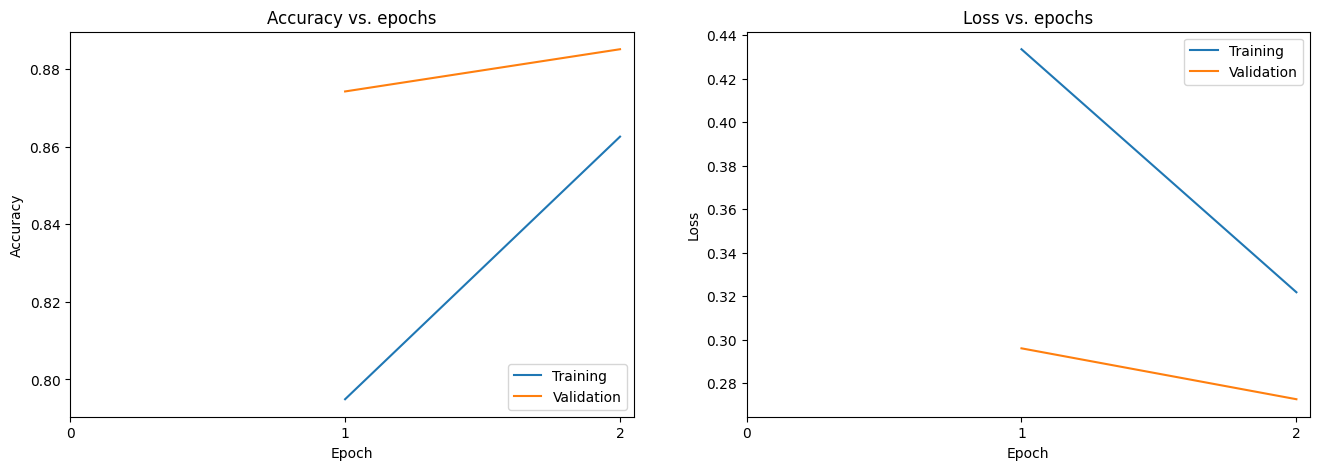

2021-12-06 08:31:26,042: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft
----------------------------------------evaluate----------------------------------------


2021-12-06 08:34:42,542: INFO: test loss:0.2725
2021-12-06 08:34:42,543: INFO: test accuracy:0.8851
2021-12-06 08:34:42,544: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2021-12-06 08:34:42,546: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2021-12-06 08:34:42,547: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2021-12-06 08:34:42,608: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.pkl
2021-12-06 08:34:42,610: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2021-12-06 08:34:42,611: INFO: loading 

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-12-06 08:34:43,123: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_preproess.generator


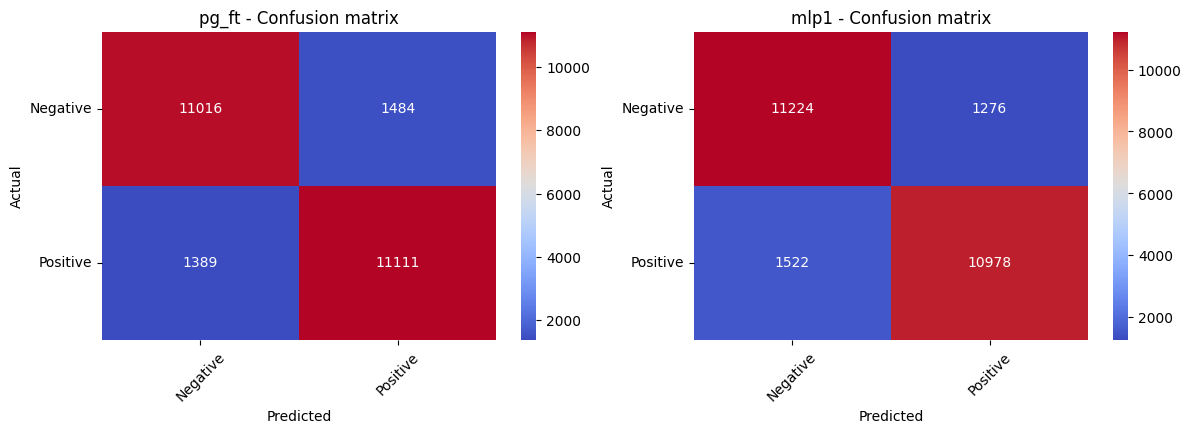

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,mlp1,imdb_0721_p100.ipynb,5120770,10.9,2021-12-06 06:22,0.1834,0.2765,0.9390,0.8881,0.9848,0.9558
2,mlp2,imdb_0721_p100.ipynb,5120770,32.9,2021-12-06 06:24,0.2824,0.3481,0.9306,0.8871,0.9809,0.9529
3,pg_ft,imdb_0721_p100.ipynb,184002,298.6,2021-12-06 08:34,0.2675,0.2725,0.8882,0.8851,0.9563,0.9547
4,embedding1,imdb_0721_p100.ipynb,4000802,386.0,2021-12-06 06:35,0.1578,0.2761,0.9481,0.8838,0.9884,0.9541
5,embedding2,imdb_0721_p100.ipynb,4000802,408.6,2021-12-06 06:43,0.1683,0.2790,0.9431,0.8830,0.9857,0.9526
6,pg_default,imdb_0721_p100.ipynb,6184002,180.5,2021-12-06 08:25,0.2114,0.2938,0.9194,0.8744,0.9762,0.9507
7,rnn_lstm_ft,imdb_0721_p100.ipynb,1282802,1739.8,2021-12-06 08:16,0.6313,0.6379,0.6742,0.6656,0.6906,0.6791
8,rnn_lstm,imdb_0721_p100.ipynb,5123002,1556.7,2021-12-06 07:39,0.6893,0.6920,0.5247,0.5092,0.5337,0.5157


In [37]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.pooled_gru1(helper, name='pg_ft', 
                       embedding_matrix=embedding_matrix_fasttext, 
                       is_embedding_trainable=False)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

## 评估

### 最佳模型

In [38]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10, columns=['program_name', 'model_name', 'create_time', 'test_loss', 'test_accuracy'])

2021-12-06 08:36:15,911: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb
2021-12-06 08:36:15,912: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json


,program_name,model_name,create_time,test_loss,test_accuracy
1,imdb_0721_p100.ipynb,mlp1,2021-12-06 06:22,0.2765,0.8881
2,imdb_0721_p100.ipynb,mlp2,2021-12-06 06:24,0.3481,0.8871
3,imdb_0721_p100.ipynb,pg_ft,2021-12-06 08:34,0.2725,0.8851
4,imdb_0721_p100.ipynb,embedding1,2021-12-06 06:35,0.2761,0.8838
5,imdb_0721_p100.ipynb,embedding2,2021-12-06 06:43,0.2790,0.8830
6,imdb_0721_p100.ipynb,pg_default,2021-12-06 08:25,0.2938,0.8744
7,imdb_0721_p100.ipynb,rnn_lstm_ft,2021-12-06 08:16,0.6379,0.6656
8,imdb_0721_p100.ipynb,rnn_lstm,2021-12-06 07:39,0.6920,0.5092


In [39]:
predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
print(len(helper.datasets.train_data), len(helper.datasets.train_labels))
print(helper.datasets.train_data[0:2])
print(helper.datasets.train_labels[0:2])

predictor = predictors[0]
train_result = predictor.evaluate(helper.datasets.train_data, helper.datasets.train_labels)
train_result

2021-12-06 08:36:15,995: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1
2021-12-06 08:36:16,489: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_preproess.generator
2021-12-06 08:36:16,982: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2
2021-12-06 08:36:17,526: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_map.generator
2021-12-06 08:36:17,528: INFO: loading layer from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_map.pkl
2021-12-06 08:36:17,578: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/i

25000 25000
["POSSIBLE SPOILERS<br /><br />The Spy Who Shagged Me is a muchly overrated and over-hyped sequel. International Man of Mystery came straight out of the blue. It was a lone star that few people had heard of. But it was stunningly original, had sophisticated humour and ample humour, always kept in good taste, and had a brilliant cast. The Spy Who Shagged Me was a lot more commercially advertised and hyped about.<br /><br />OK I'll admit, the first time I saw this film I thought it was very funny, but it's only after watching it two or three times that you see all the flaws. The acting was OK, but Heather Graham cannot act. Her performance didn't seem very convincing and she wasn't near as good as Liz Hurley was in the first one. Those characters who bloomed in the first one, (Scott Evil, Number 2 etc.) are thrown into the background hear and don't get many stand-alone scenes. The film is simply overrun with cameos.<br /><br />In particular, I hated the way they totally disre

{'loss': 0.18335095047950745, 'accuracy': 0.9389600157737732}

In [40]:
for predictor in predictors:
    print('-'*50)
#     print(predictor.model.summary())
    try:
        train_result = predictor.evaluate(helper.datasets.train_data, self.datasets.train_labels)
#         print(predictor.predict(train_texts[1:3]))
    except Exception as e:
        print(e)

--------------------------------------------------
name 'self' is not defined
--------------------------------------------------
name 'self' is not defined
--------------------------------------------------
name 'self' is not defined
--------------------------------------------------
name 'self' is not defined
--------------------------------------------------
name 'self' is not defined


In [41]:


best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


None

----------------------------------------1. Positive----------------------------------------
Hey all you jive hustlers, you stone foxes, you mean dudes. Watch out cause Slaughter is back in town! If you are looking for a bad-ass, funky film to watch some night, this is just right. 'Slaughter' is back and trying to take it easy n' relax after his adventures down in Mexico. But if you are a narrow-minded gangster like 'Duncan', you are bound to seek revenge. Why, I don't know. Was 'Hoffo' in the first one his brother or what? Any who. The movie starts off with the old "assassination from a plane" routine. We all know that that is THE most effective way for taking out one guy in a picnic, full of people. Needless to say Slaughter survives the ordeal, but Cmndt. Eric Lassard, sorry George Gaynes I mean isn't that lucky. SMACK!! Also Slaughters best friend Pratt is killed. This is the start of a grand adventure, filled with the hippest, funkiest music James Brown himself has to offer. That's

2021-12-06 08:38:31,818: WARNING: 5 out of the last 786 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7faf447c5ee0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2021-12-06 08:38:32,038: WARNING: 6 out of the last 787 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fb09a23bf70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


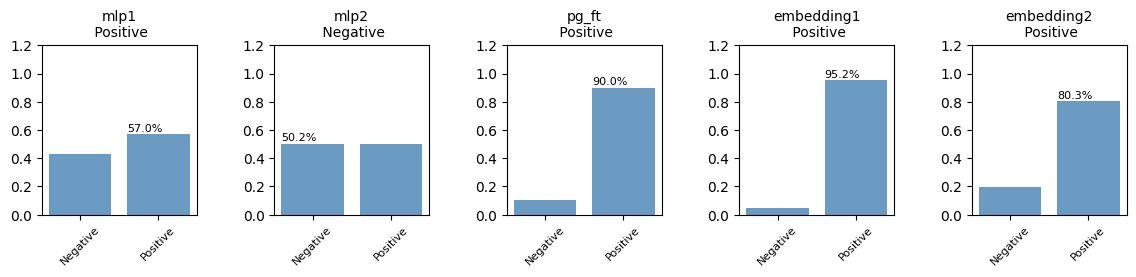

----------------------------------------2. Positive----------------------------------------
... The reason I like this movie so much is because of the spirit it has. It's a genial summer camp movie, so the jokes aren't mean minded in a lasting way that makes one character the permanent butt of ridicule. Pranks do take place, but you get the feeling that the respective fall-guys would be able to look back and laugh, having been dopey enough to fall for them - and without being too cheesy, it's actually kinda nice that everyone still remains friends in the end!<br /><br />It's an extra special bonus when the ringmaster of all these jolly japes is Bill Murray. For me, he's still looked upon as the comedy god without peer when he gets a chance to cut loose. No one's better at generating a sense of freewheeling wacky anarchy without really hurting anyone. The tone of the entire film has the same style as its leading man, established with a great opening scene showing the Murray way of getti

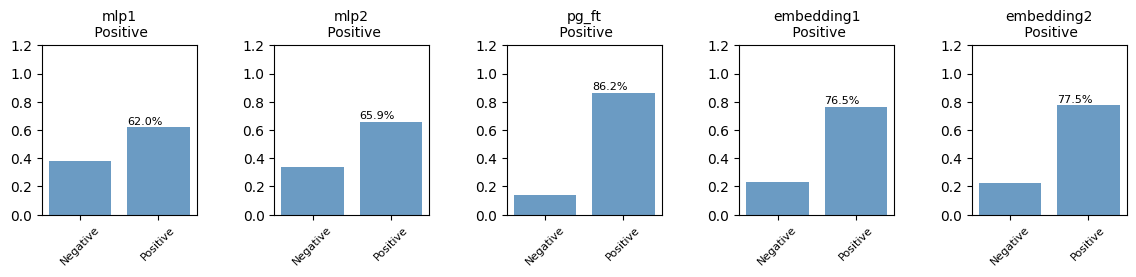

----------------------------------------3. Positive----------------------------------------
Duchess is a pretty white cat who lives with her three kittens in her wealthy owner's mansion in Paris. When the evil butler hears that the rich old lady is leaving everything in her will to the cats first, the butler is angered, because he wants to get everything first. So he puts them to sleep and abandons them off the side of the road. When the cats wake up, they start on a long trek home. A street wise cat named Thomas O'Malley meets up with them and offers to help them. When Edgar sees them arriving home, he is furious, and starts to mail them to Timbucktu. But Thomas' friends arrive to help save the day. The wealthy lady decides to leave her home for every alley cat in Paris.<br /><br />This is a charming film. The songs, including "Everybody Wants to be a Cat", are lively and upbeat. The voice cast is excellent, with Eva Gabor(who would later play Miss Bianca in Disney's THE RESCUERS film

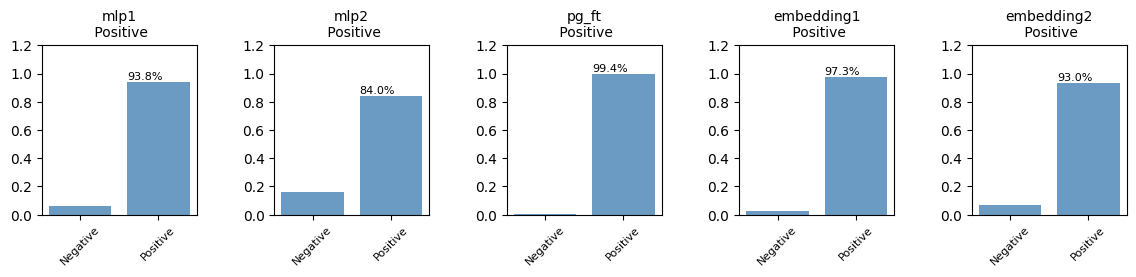

----------------------------------------4. Negative----------------------------------------
Silly comedy casts an embarrassed-seeming Ray Milland as a British officer in World War II Europe escaping German confines and taking up with a man-hungry gypsy woman, played by Marlene Dietrich. Slowly-paced, overlong, and miscast: the leads are far too old for this type of juvenile fodder, although Marlene shines in her solo moments. It took three scriptwriters to adapt Yolanda Foldes' book for the screen, but this material must have already seemed dated by 1947--it smacks of something Ernst Lubitsch might have turned out in 1939. The scenario is musty, and the stars have absolutely no chemistry together. ** from ****


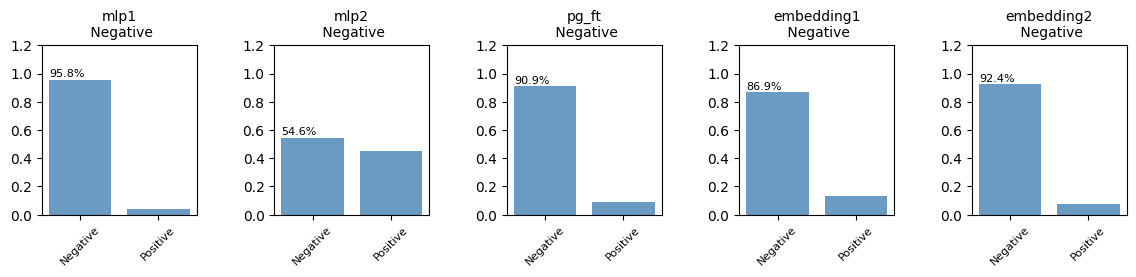

----------------------------------------5. Negative----------------------------------------
Mercy the movie, actually starts out as a somewhat decent film, and ellen barkin does give a strong performance. But if you have read the book and actually got to know the characters and cared who done it the movie just does not compare. It is always hard to brink a book onto film and unfortunatley this one ends up failing...... 3 out of 10


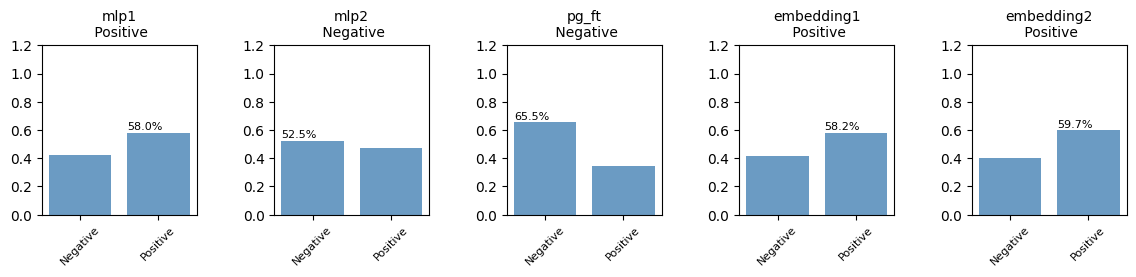

In [43]:
qtf.utils.plot_sample_text_analysis(predictors, test_texts, test_labels,
                                    sample_count=5, show_error_sample=False) 

<class 'list'>
----------------------------------------1. Positive----------------------------------------
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


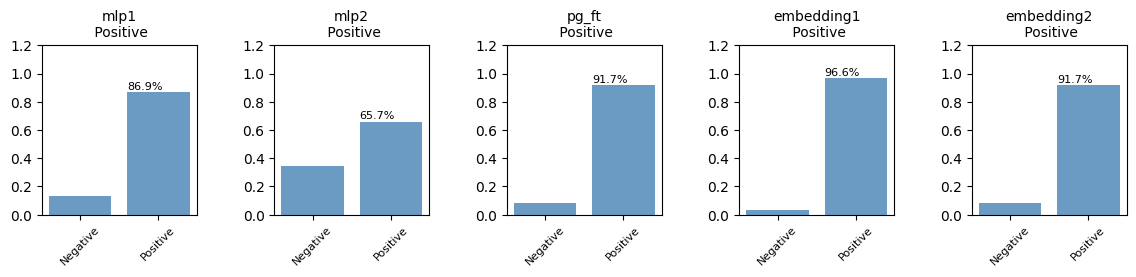

----------------------------------------2. Negative----------------------------------------
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


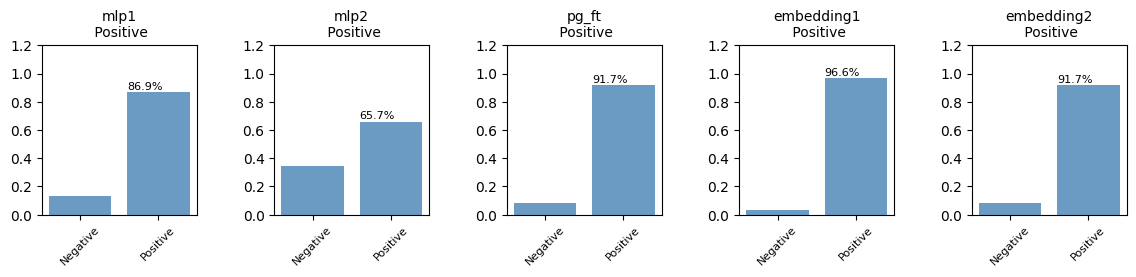

----------------------------------------3. Negative----------------------------------------
Actor turned director Bill Paxton follows up his promising debut, the Gothic-horror "Frailty", with this family friendly sports drama about the 1913 U.S. Open where a young American caddy rises from his humble background to play against his Bristish idol in what was dubbed as "The Greatest Game Ever Played." I'm no fan of golf, and these scrappy underdog sports flicks are a dime a dozen (most recently done to grand effect with "Miracle" and "Cinderella Man"), but some how this film was enthralling all the same.<br /><br />The film starts with some creative opening credits (imagine a Disneyfied version of the animated opening credits of HBO's "Carnivale" and "Rome"), but lumbers along slowly for its first by-the-numbers hour. Once the action moves to the U.S. Open things pick up very well. Paxton does a nice job and shows a knack for effective directorial flourishes (I loved the rain-soaked monta

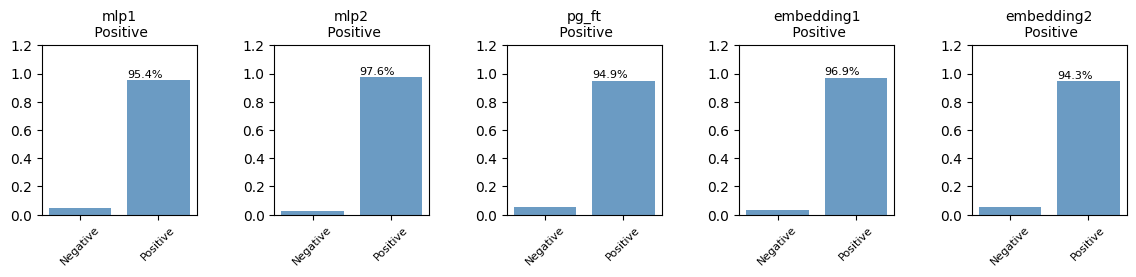

----------------------------------------4. Positive----------------------------------------
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


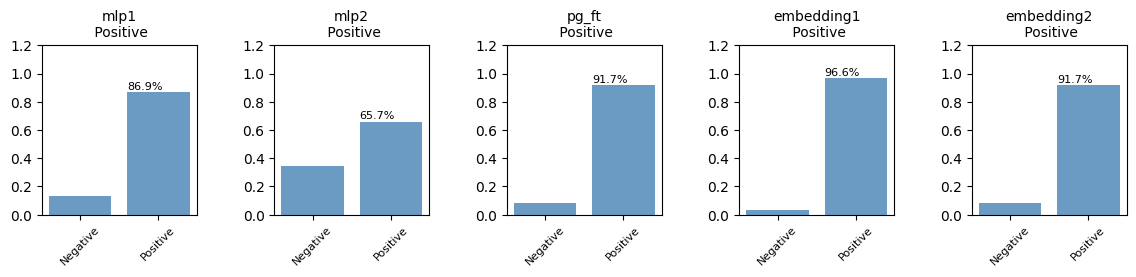

----------------------------------------5. Positive----------------------------------------
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


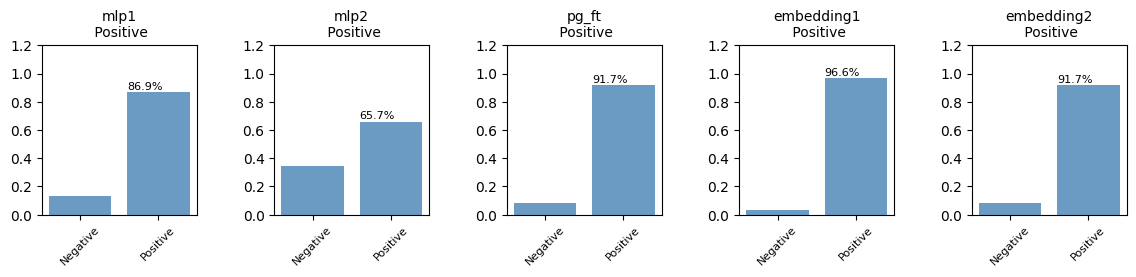

In [44]:
qtf.utils.plot_sample_text_analysis(predictors, test_texts, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [45]:
results = best_predictor.evaluate(test_texts, test_labels)
print(results)

predictions = best_predictor.predict(test_texts)
print(predictions.shape)

{'loss': 0.27647915482521057, 'accuracy': 0.8880800008773804, 'mae': 1.6496914625167847}
(25000, 2)


In [46]:
top1_predictions = best_predictor.predict_top_k(test_texts, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

,precision,recall,f1
Negative,0.880590,0.89792,0.889171
Positive,0.895871,0.87824,0.886968


----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative     0.8806    0.8979    0.8892     12500
    Positive     0.8959    0.8782    0.8870     12500

    accuracy                         0.8881     25000
   macro avg     0.8882    0.8881    0.8881     25000
weighted avg     0.8882    0.8881    0.8881     25000



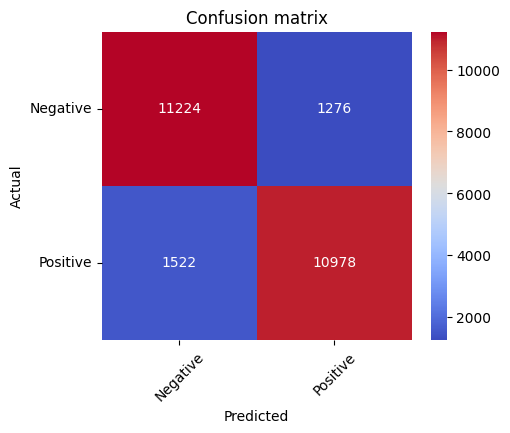

In [47]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)